# US State House Elections 2016 + 2020

The goal of this project was to be able to predict election results from the 2016 and 2020 US State House of Representative Elections reasonably well and thereby gain experience in an end to end Data Science workflow.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install catboost
from catboost import CatBoostClassifier
!pip install empiricaldist
from empiricaldist import Cdf
!pip install sktools
from sktools import GradientBoostingFeatureGenerator
!pip install empiricaldist
from empiricaldist import Cdf
from scipy.stats import ttest_ind
from collections import Counter
!pip install mrmr_selection
from mrmr import mrmr_classif

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 93 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for empiricaldist: filename=empiricaldist-0.6.7-py3-none-any.whl size=11972 sha256=0f8a0ae990b16b7b5caf6bbb4668267f0600eb370e06e1e9c0178741661ddbdf
  Stored in directory: /root/.cache/pip/wheels/dd/dc/1c/c472efa84814edbb5b67d132ad3950534d0d7fd808543a659c
Successfully built empiricaldist
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.0 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df_2016 = pd.read_csv("drive/MyDrive/US Elections/data_final_2016.csv")
df_2020 = pd.read_csv("drive/MyDrive/US Elections/data_final_2020.csv")

In [3]:
df = pd.concat([df_2016, df_2020])
df = df.reset_index(drop=True)

pd.set_option("display.max_columns", None)
df.head()

,district,percent households receiving food stamps,state,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,native,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,democrat,republican,other,year,target,office
0,1,14.1,alaska,18.3,15.4,0.369463,0.088753,0.4755,23.0,31.7,15.6,19.1,10.4,31.8,9.6,26.9,46.3,14.7,1165.0,42.3,3.34,0.9144,0.0856,15.3,0.2823,0.2360,0.2810,0.2008,0.1792,0.4074,0.2382,0.1752,30518,0.1055,0.3204,0.3830,0.1911,1.0,0.0,0.0,2016,1,NaN
1,2,7.2,alaska,8.1,15.0,0.259593,0.063050,0.4379,33.2,38.7,14.1,8.9,5.2,25.2,4.5,15.4,40.6,35.0,1674.0,36.9,3.43,0.9345,0.0655,6.4,0.3377,0.2091,0.2682,0.1850,0.2422,0.3664,0.2042,0.1872,31519,0.0500,0.3044,0.4334,0.2122,1153.0,3268.0,0.0,2016,0,NaN
2,3,5.4,alaska,11.0,6.4,0.178482,0.022357,0.4623,31.5,22.9,20.2,18.8,6.6,31.7,7.2,17.6,43.7,30.9,1680.0,74.4,3.48,0.9707,0.0293,7.4,0.3624,0.1202,0.2143,0.3031,0.1030,0.3200,0.3270,0.2500,38923,0.0589,0.2771,0.4483,0.2158,537.0,4291.0,2270.0,2016,0,NaN
3,4,4.7,alaska,8.2,6.5,0.102099,0.002420,0.4416,23.0,27.2,18.0,21.6,10.1,34.9,9.2,25.2,40.2,22.5,1328.0,76.4,3.19,0.9857,0.0143,5.1,0.4297,0.1777,0.1743,0.2184,0.0900,0.2560,0.2400,0.4140,45965,0.0462,0.1403,0.3673,0.4461,1.0,0.0,0.0,2016,1,NaN
4,5,4.0,alaska,14.1,10.0,0.287074,0.040892,0.4618,26.5,25.2,21.2,19.2,8.0,33.7,10.0,25.0,44.7,20.0,1242.0,64.7,3.46,0.9405,0.0595,5.9,0.4315,0.1362,0.2408,0.1915,0.0870,0.3300,0.2200,0.3630,36468,0.0534,0.1915,0.4128,0.3423,3812.0,3384.0,0.0,2016,1,NaN


In [4]:
# Change all percentage values between 0 and 1 to an absolute number
percentage_cols_change = [col for col in df.select_dtypes(["number"]).columns if df[col].max() < 1]
df[percentage_cols_change] = df[percentage_cols_change].apply(lambda x: round(x*100, 2))

# Delete districts with independent MPs
df = df.drop(df[df.target == 2].index)

In [5]:
# Delete native, parties and office columns
df.drop(["native", "republican", "democrat", "other", "office"], axis=1, inplace=True)

# Exploratory Data Analysis



## 1. Basic Exploration
Tasks:
* 4 Missing values in "monthly housing costs - median"

In [6]:
df.shape

(7554, 38)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7554 entries, 0 to 7580
Data columns (total 38 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   district                                             7554 non-null   object 
 1   percent households receiving food stamps             7554 non-null   float64
 2   state                                                7554 non-null   object 
 3   percent uninsured                                    7554 non-null   float64
 4   household language not english                       7554 non-null   float64
 5   non-white                                            7554 non-null   float64
 6   black/afroamerican                                   7554 non-null   float64
 7   percent female                                       7554 non-null   float64
 8   under 20                                             7554 non-null  

In [8]:
df.describe()

,percent households receiving food stamps,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,year,target
count,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7550.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000,7554.000000
mean,12.567487,9.395804,15.185676,22.990226,10.795649,51.472847,25.157446,20.219030,18.754743,19.979956,15.887975,39.099047,18.607710,32.065172,35.166599,13.111064,1057.399338,66.353548,3.148806,10.211995,13.851165,36.907244,17.896475,22.399974,22.796288,17.637859,37.543287,22.265322,22.553545,34319.512708,11.248636,29.331946,31.254976,28.164403,2017.982526,0.457903
std,8.013686,5.497548,15.507661,20.173216,15.904813,2.232013,4.100215,5.689813,2.385204,3.262955,4.751583,5.533918,11.805757,10.604634,11.421065,13.397450,392.508500,14.744785,0.289650,10.636877,7.581128,10.425656,4.704194,3.083179,8.151243,7.679422,8.148895,4.195756,12.544598,9596.627386,6.266347,8.292518,5.691166,13.508102,2.000056,0.498258
min,0.200000,0.200000,0.200000,0.570000,0.000000,34.620000,7.900000,6.800000,3.800000,2.970000,2.000000,18.800000,0.000000,2.040000,2.100000,0.000000,314.000000,3.600000,2.390000,0.040000,1.300000,9.170000,4.050000,6.330000,1.570000,1.830000,7.950000,7.390000,2.600000,4901.000000,0.310000,4.830000,8.930000,3.380000,2016.000000,0.000000
25%,6.700000,5.300000,4.800000,7.862500,1.360000,50.370000,22.800000,16.690000,17.400000,18.100000,12.700000,35.500000,9.212500,24.200000,26.770000,3.590000,773.000000,58.600000,2.960000,3.040000,8.100000,29.432500,14.860000,20.340000,16.760000,11.800000,32.810000,19.532500,13.302500,27692.750000,6.740000,23.740000,27.760000,17.870000,2016.000000,0.000000
50%,11.000000,8.400000,9.400000,16.210000,4.110000,51.520000,25.000000,19.065000,18.730000,20.260000,15.800000,39.300000,16.270000,33.385000,36.100000,7.730000,972.000000,69.900000,3.090000,6.480000,12.500000,34.950000,17.410000,22.395000,22.765000,16.895000,39.160000,22.410000,19.105000,32251.500000,9.935000,30.010000,31.410000,24.810000,2016.000000,0.000000
75%,16.600000,12.300000,19.400000,30.547500,12.317500,52.670000,27.440000,22.500000,20.130000,21.990000,18.600000,42.600000,26.020000,40.000000,43.180000,18.100000,1265.000000,76.800000,3.290000,13.165000,18.000000,43.117500,20.317500,24.417500,28.937500,22.580000,43.320000,25.050000,28.962500,39034.500000,14.360000,35.227500,34.727500,35.742500,2020.000000,1.000000
max,57.100000,44.700000,90.800000,98.030000,96.840000,61.580000,50.700000,71.430000,31.300000,34.200000,53.820000,66.600000,72.880000,64.400000,74.660000,79.630000,3680.000000,97.500000,5.060000,80.120000,53.200000,80.660000,44.010000,34.700000,52.640000,52.500000,62.950000,39.720000,77.460000,99643.000000,51.140000,51.540000,70.820000,81.150000,2020.000000,1.000000


## Target Variable Distribution

0    4095
1    3459
Name: target, dtype: int64



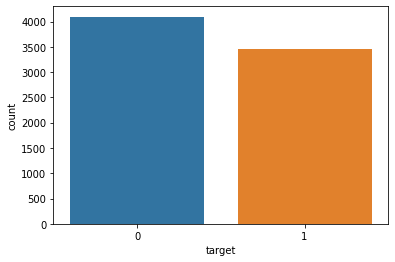

In [9]:
print(df.target.value_counts())
print()
sns.countplot(x="target", data=df);

In [10]:
print("Percentage of Target Values")
round(df.target.value_counts() / df.target.value_counts().sum() * 100, 2)

Percentage of Target Values


0    54.21
1    45.79
Name: target, dtype: float64

Target variable is slightly imbalanced. While 54% of all districts elected a republican candidate and Democrats were elected in 45% of all districts.

## Data Splitting

In [11]:
# Stratified Sampling
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.25, stratify=df.target, random_state=42)

In [12]:
train.target.value_counts()

0    3071
1    2594
Name: target, dtype: int64

In [13]:
test.target.value_counts()

0    1024
1     865
Name: target, dtype: int64

In [14]:
X_test = test.drop("target", axis=1)
y_test = test.target

In [15]:
num_cols = train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

## Visualizations

### Univariate Exploration

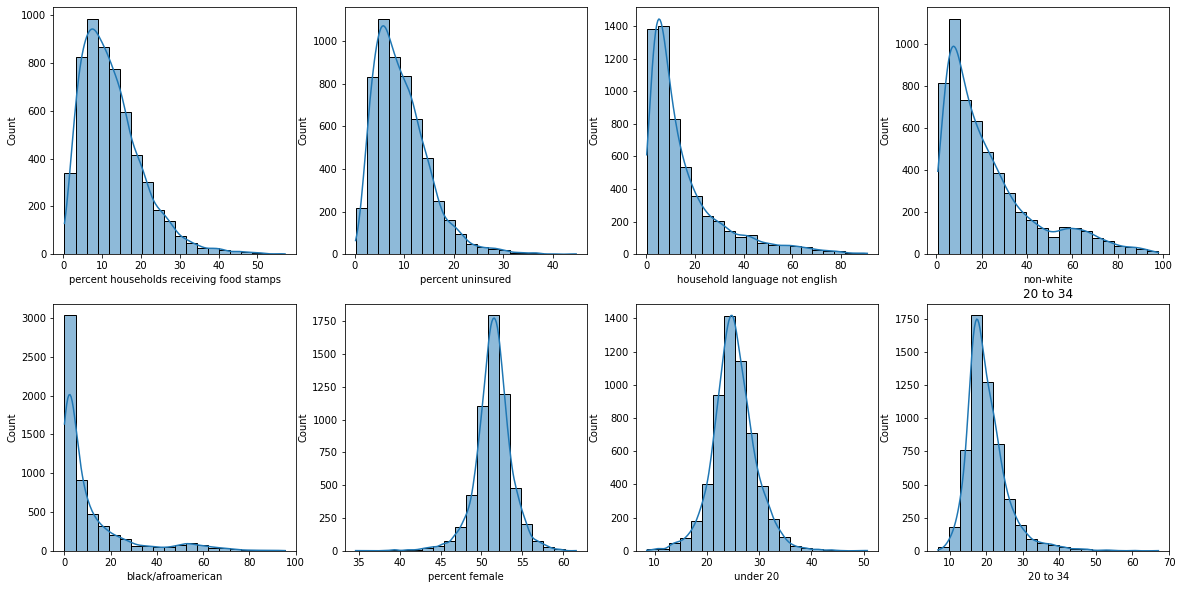

In [16]:
# only first few features for storage capacity reasons
fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         figsize=(20, 10))
for ax, col in zip(axes.flatten(), train[num_cols].columns[:8]):
  sns.histplot(x=col, data=train, bins=20, kde=True, ax=ax)
  plt.title(col);

In [ ]:
# Check for skewness and kurtosis of the data (-> how far from normally distributed variables are)
normal_dist = pd.DataFrame()
normal_dist["skew"] = train.select_dtypes(include=["number"]).skew()
normal_dist["kurtosis"] = train.select_dtypes(include=["number"]).kurtosis()
normal_dist

,skew,kurtosis
percent households receiving food stamps,1.285262,2.427372
percent uninsured,1.297638,2.764714
household language not english,1.930569,3.794968
non-white,1.385395,1.305108
black/afroamerican,2.343439,5.289239
percent female,-0.580336,3.516022
under 20,0.239425,1.798852
20 to 34,1.768992,5.980625
35 to 49,-0.173592,2.055864
50 to 64,-0.342480,1.104877


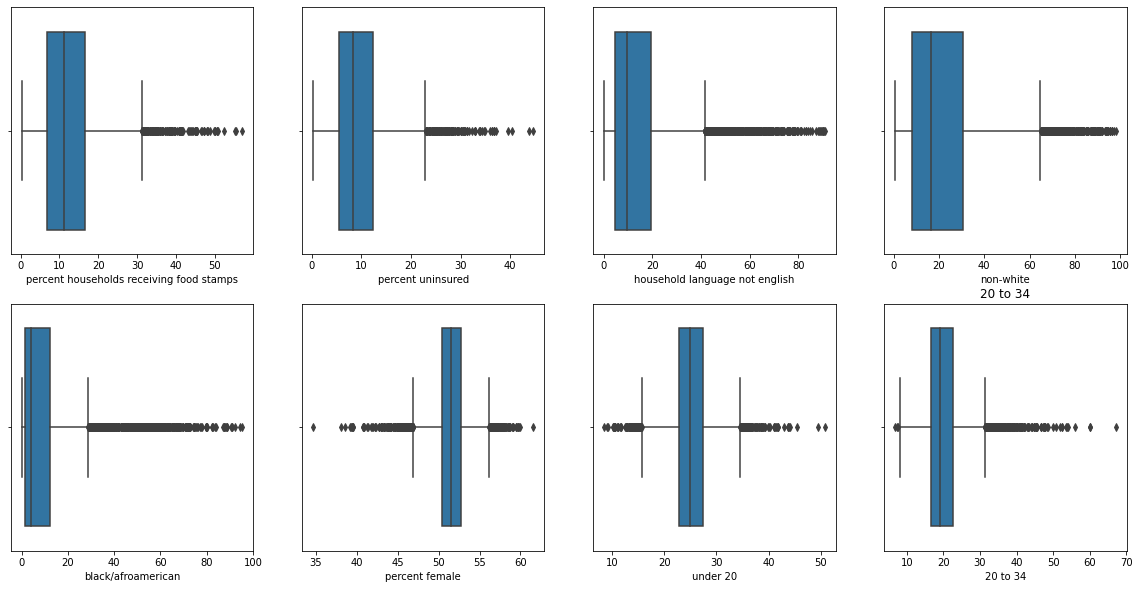

In [17]:
# Distribution of variables with boxplots
# only first few features for storage capacity reasons
fig, axes = plt.subplots(nrows=2,
                       ncols=4,
                       figsize=(20, 10))

for ax, col in zip(axes.flatten(), train[num_cols].columns[:8]):
  sns.boxplot(x=train[col], ax = ax)
  plt.title(col);

### Bivariate Exploration

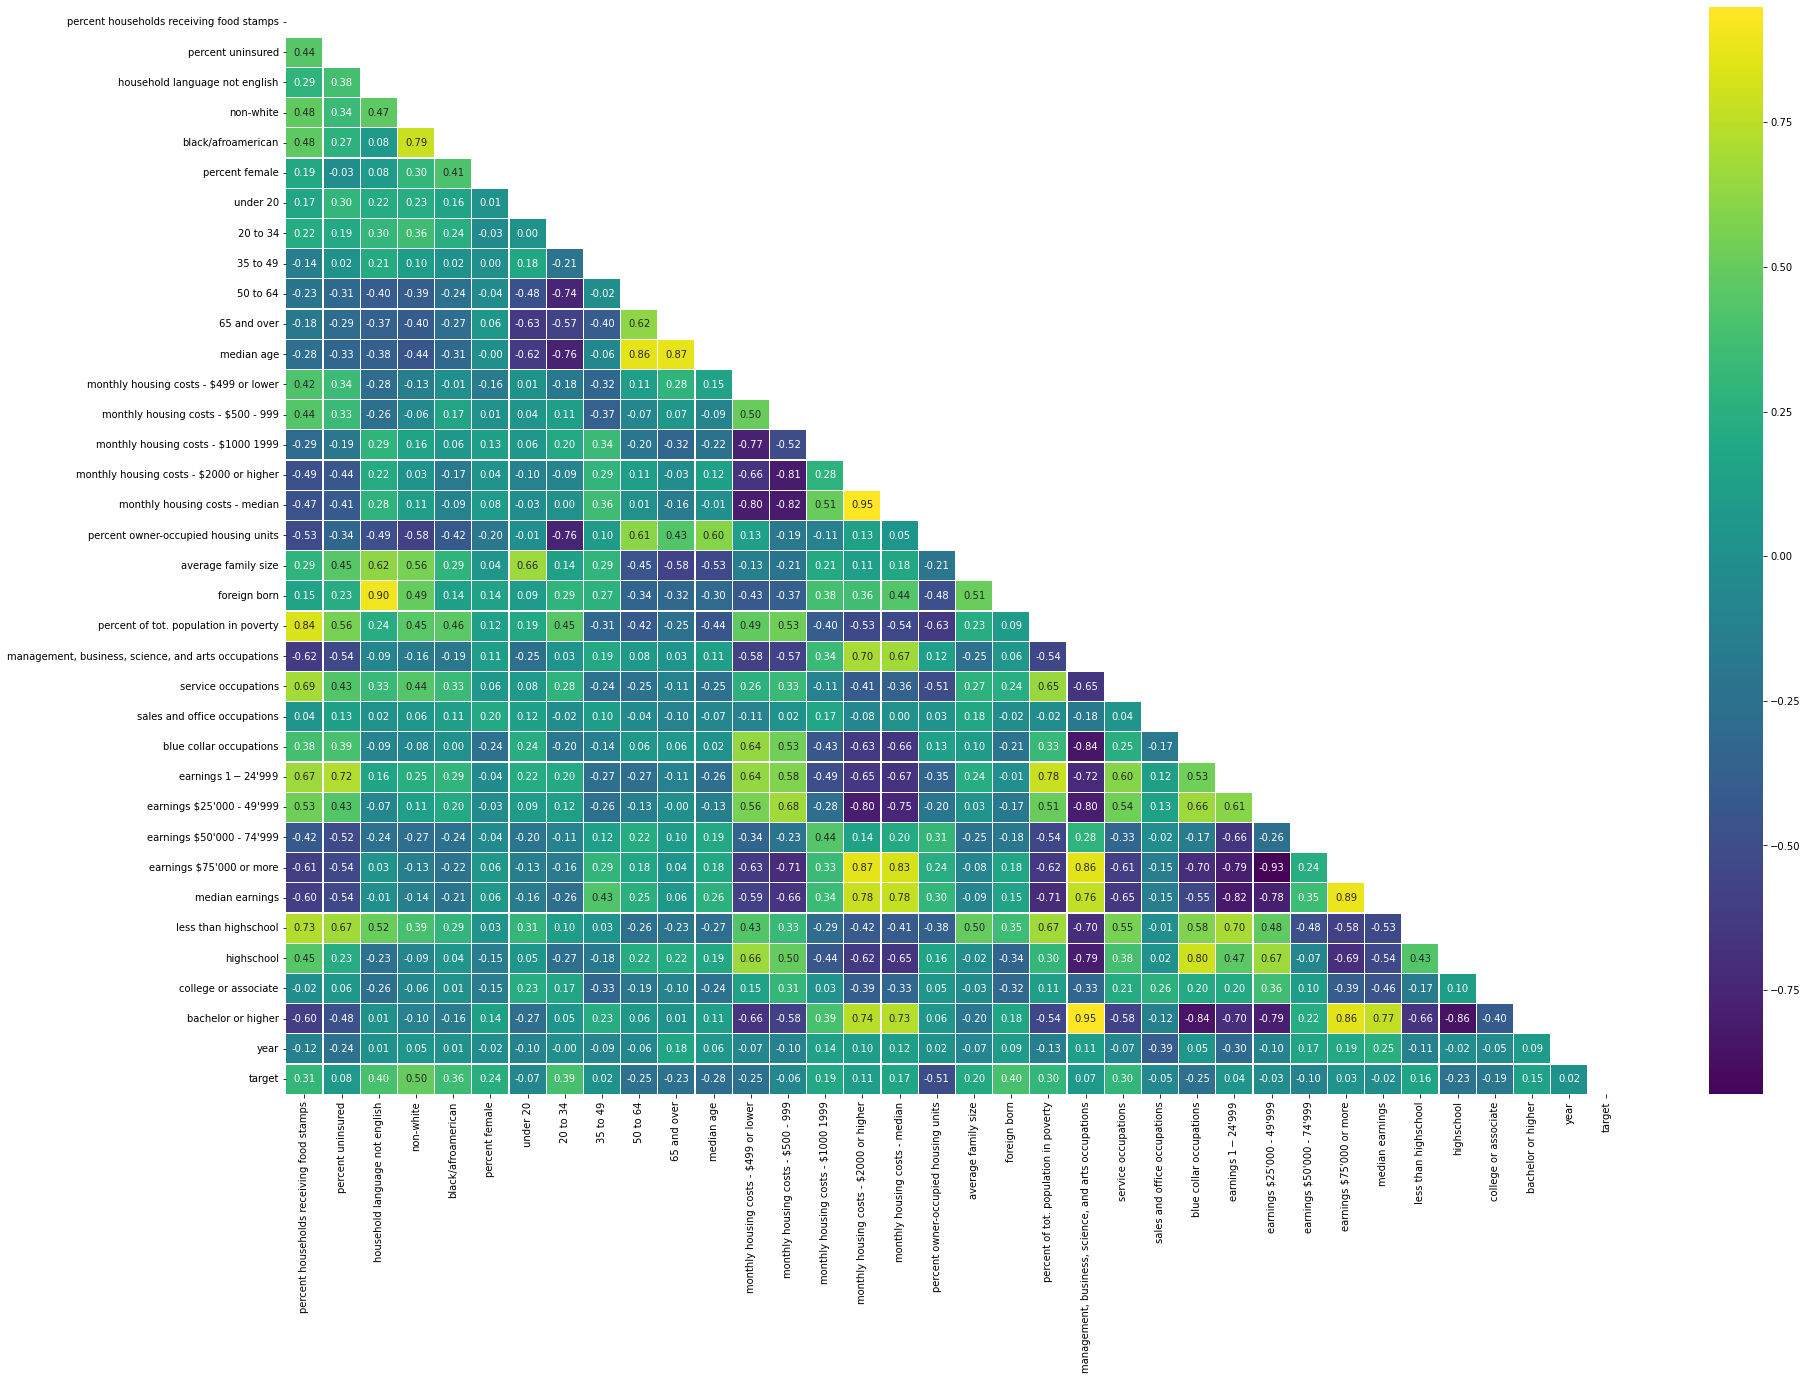

In [ ]:
# Check for correlation of features
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(30, 20))
a = sns.heatmap(data=corr_matrix, 
                cmap="viridis",
                center=0,
                annot=True,
                fmt=".2f",
                lw=0.3,
                mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))

In [ ]:
# Features with high correlation to target
corr_matrix["target"].abs().sort_values(ascending=False)[:15]

target                                      1.000000
percent owner-occupied housing units        0.507908
non-white                                   0.500775
foreign born                                0.397366
household language not english              0.395058
20 to 34                                    0.389238
black/afroamerican                          0.359255
percent households receiving food stamps    0.309411
service occupations                         0.300894
percent of tot. population in poverty       0.297264
median age                                  0.280985
50 to 64                                    0.251538
blue collar occupations                     0.249217
monthly housing costs - $499 or lower       0.246653
percent female                              0.244857
Name: target, dtype: float64

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import ttest_ind
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline

### only first few features for storage capacity reasons

def pval_auc(df):
  """This function produces a grid of boxplots where each feature is analyzed 
  for both target characteristics. Additionally, two models are calculated for 
  each feature. One dummy/naive model and one model with the respective feature 
  as input. The features are transformed to a more normal distribution. 
  The p-value states if the means of the cross-validated AUC scores of the model 
  with the feature are bigger than the means of the naive model. The boxplots 
  are in descending order by p-value which means that the last features should 
  have the least predictive power."""
  
  # Make copy of df to fill in NAs with median
  df_new = df.copy()
  df_new.fillna(df["monthly housing costs - median"].median(), inplace=True)

  # Make list array of auc scores for dummy classifier which constantly predicts majority class
  dummy_scores = np.array([0.5] * 10)
  # List to save p values
  p_values = []

  # Pipeline with normalization, standardization and Logistic Regression
  pipe = Pipeline(steps=[("norm_stand", PowerTransformer()), ("log_reg", LogisticRegression(random_state=42))])

  # Loop through all numeric cols excep target and calculate auc score with cross validation
  for num, col in enumerate(df_new[num_cols].drop("target", axis=1).columns[:10]):
    test_scores = cross_val_score(pipe, 
                                  df_new[col].to_frame(), 
                                  df_new.target, 
                                  cv=10, 
                                  scoring="roc_auc",
                                  n_jobs=-1)
    # Calculate p values between auc scores of respective col and dummy classifier to see whether classifier with variable is better at predicting party
    # alternative = greater means one sided t-test (checks whether mean of test_scores greater than mean of dummy_scores)
    _, pval = ttest_ind(test_scores, dummy_scores, alternative="greater")
    p_values.append(pval)
  
  # Save features and pvalues in a sorted list from lowerst to highest pvalue
  feature_pvalues = sorted(list(zip(p_values, df_new[num_cols].columns)))

  # Create a list of sorted column names to plot them
  features, pvalue_sorted = [], []
  for pval, col in sorted(feature_pvalues):
    pvalue_sorted.append(pval)
    features.append(col)

  # Add plots to the figure
  fig, ax = plt.subplots(nrows=2,
                    ncols=5,
                    figsize=(20,10))

  for num, ax, col, pval in zip(np.arange(0, 10), ax.flatten(), features, pvalue_sorted):    
    sns.boxplot(x=train["target"], y=train[col], ax=ax) #PowerTransformer().fit_transform(train[col].to_frame()).flatten()
    ax.set_title(f"p-value: {round(pval, 4)}")
    ax.set_xlabel("party")
    ax.set_ylabel(col)
    ax.set_xticklabels(["rep", "dem"])
  fig.tight_layout()
  # return a sorted list of p values
  return feature_pvalues

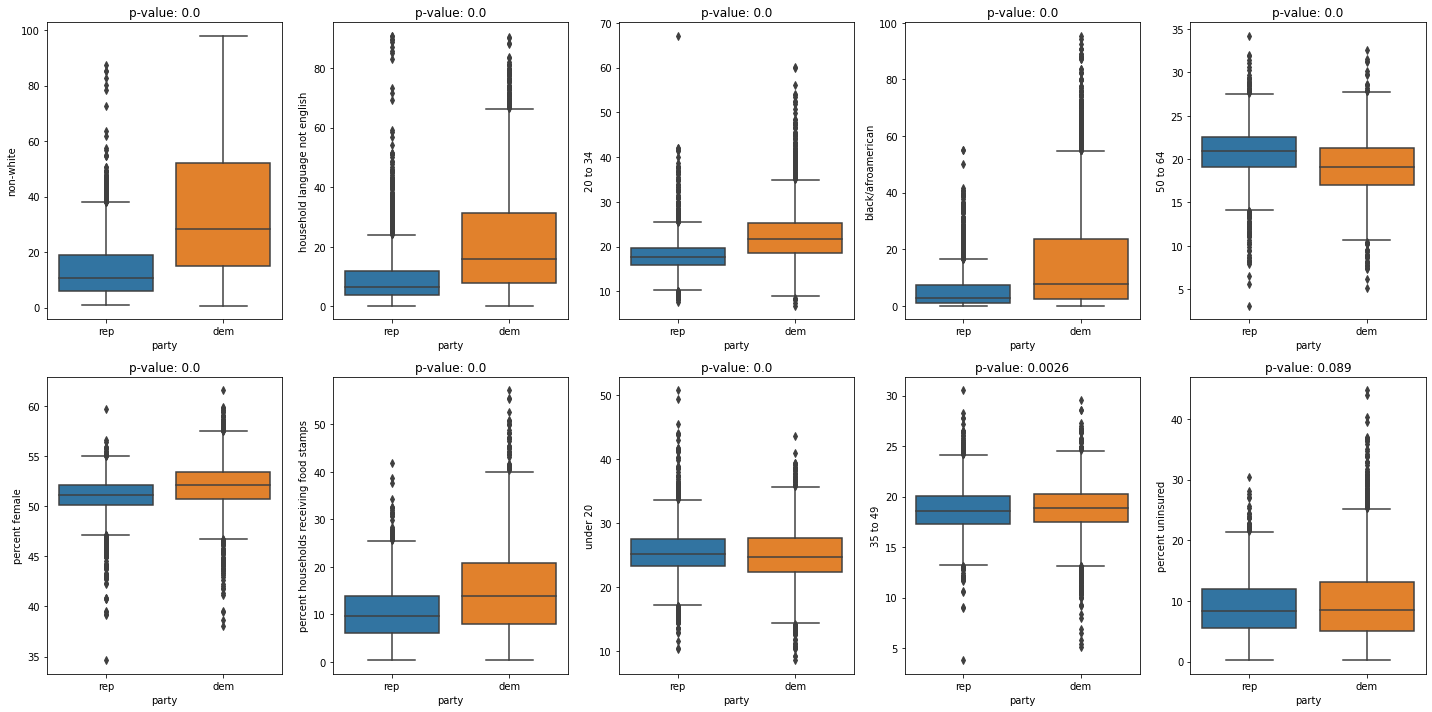

In [19]:
feature_pvalues = pval_auc(train)

### Multivariate Exploration

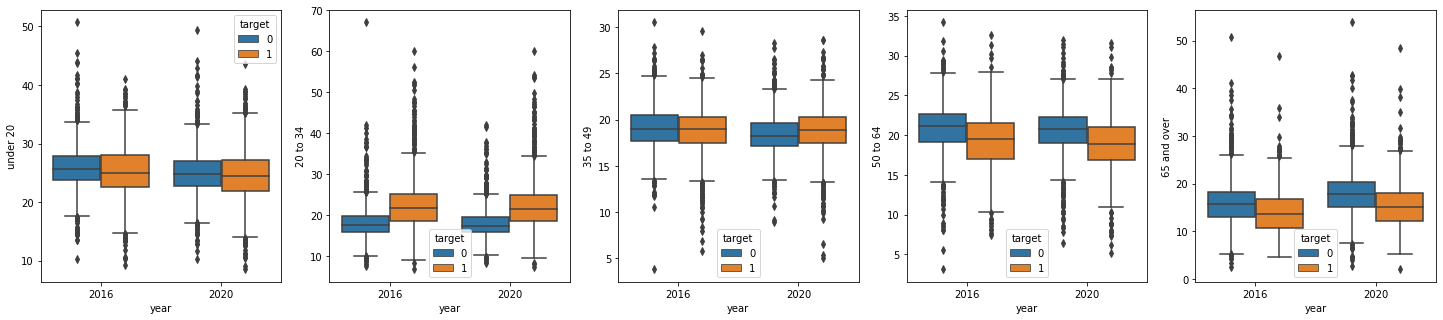

In [ ]:
# Age cohorts
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
sns.boxplot(x="year", y="under 20", hue="target", data=train, ax=ax[0])
sns.boxplot(x="year", y="20 to 34", hue="target", data=train, ax=ax[1])
sns.boxplot(x="year", y="35 to 49", hue="target", data=train, ax=ax[2])
sns.boxplot(x="year", y="50 to 64", hue="target", data=train, ax=ax[3])
sns.boxplot(x="year", y="65 and over", hue="target", data=train, ax=ax[4])

The higher the share of older people in a district the more likely a republican got elected. While especially districts with a higher percentage of 20 to 34 year old seem to have voted more often for democrats.

(0.0, 100.0)

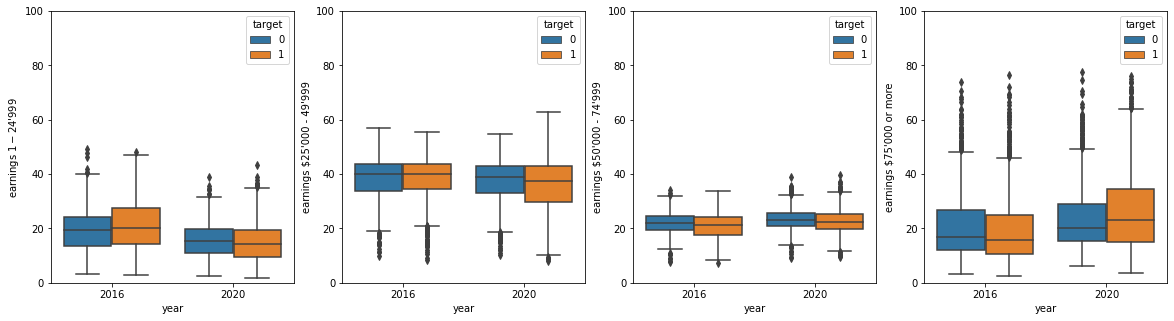

In [ ]:
# Earning cohorts
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="earnings $1 - $24'999", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $25'000 - 49'999", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $50'000 - 74'999", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="earnings $75'000 or more", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

Very identical distributions in earning cohorts for both electorates over both years.

(0.0, 100.0)

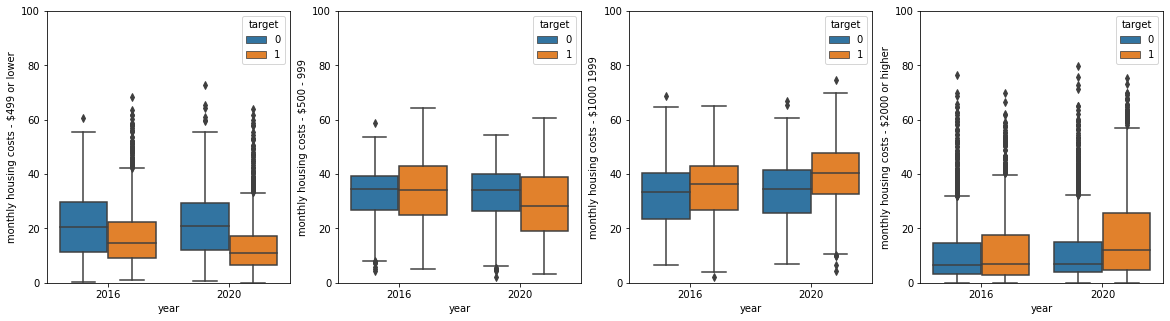

In [ ]:
# Monthly Housing Costs
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="monthly housing costs - $499 or lower", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $500 - 999", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $1000 1999", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="monthly housing costs - $2000 or higher", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

Especially in 2020: The more low price homes in a district, the more often a republican got elected. <br>
Whereas with more high prices homes, the chances of a democrat were higher. 

(0.0, 100.0)

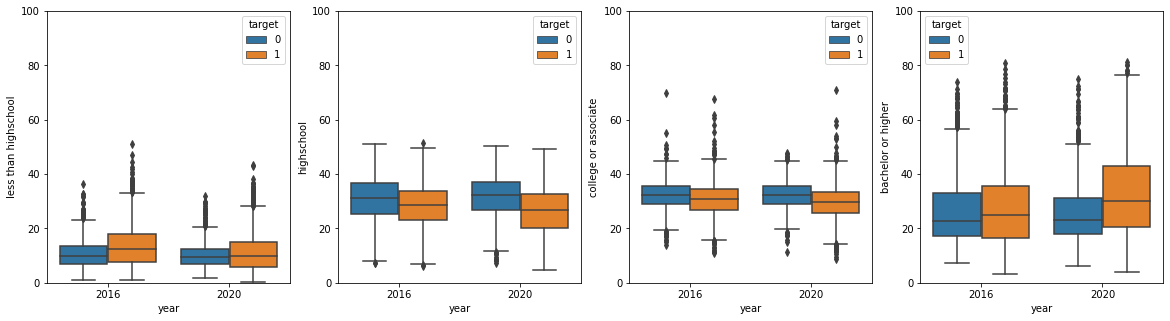

In [ ]:
# Educational Attainment
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x="year", y="less than highschool", hue="target", data=train, ax=ax[0])
ax[0].set_ylim([0, 100])
sns.boxplot(x="year", y="highschool", hue="target", data=train, ax=ax[1])
ax[1].set_ylim([0, 100])
sns.boxplot(x="year", y="college or associate", hue="target", data=train, ax=ax[2])
ax[2].set_ylim([0, 100])
sns.boxplot(x="year", y="bachelor or higher", hue="target", data=train, ax=ax[3])
ax[3].set_ylim([0, 100])

These plots show a classic middle-class voting behaviour for the Republicans: 
* The higher the percentage of people in a district with max. highschool or college degree, the higher the chances for an elected republican candidate.
* More uneducated and highly educated people in a district: Higher probability for democrat candidate.

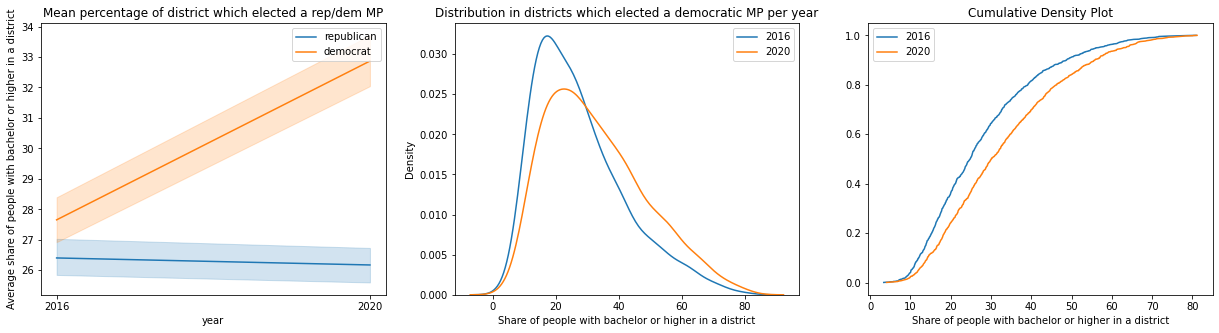

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(21, 5))
sns.lineplot(x="year", y="bachelor or higher", hue="target", data=train, ax=ax0)
ax0.set_title("Mean percentage of district which elected a rep/dem MP")
ax0.set_xticks([2016, 2020])
ax0.set_ylabel("Average share of people with bachelor or higher in a district")
ax0.legend(["republican", "democrat"])

sns.kdeplot(train[(train.target==1) & (train.year == 2016)]["bachelor or higher"], ax=ax1)
sns.kdeplot(train[(train.target==1) & (train.year == 2020)]["bachelor or higher"], ax=ax1)
ax1.legend(["2016", "2020"])
ax1.set_title("Distribution in districts which elected a democratic MP per year")
ax1.set_xlabel("Share of people with bachelor or higher in a district")

Cdf.from_seq(train[(train.target==1) & (train.year == 2016)]["bachelor or higher"]).plot(ax=ax2)
Cdf.from_seq(train[(train.target==1) & (train.year == 2020)]["bachelor or higher"]).plot(ax=ax2)
ax2.set_title("Cumulative Density Plot")
ax2.set_xlabel("Share of people with bachelor or higher in a district")
ax2.legend(["2016", "2020"]);

This plots show that districts, which elected democratic candidates, had a higher share of people with a bachelor degree or higher. This intensified in the 2020 elections.

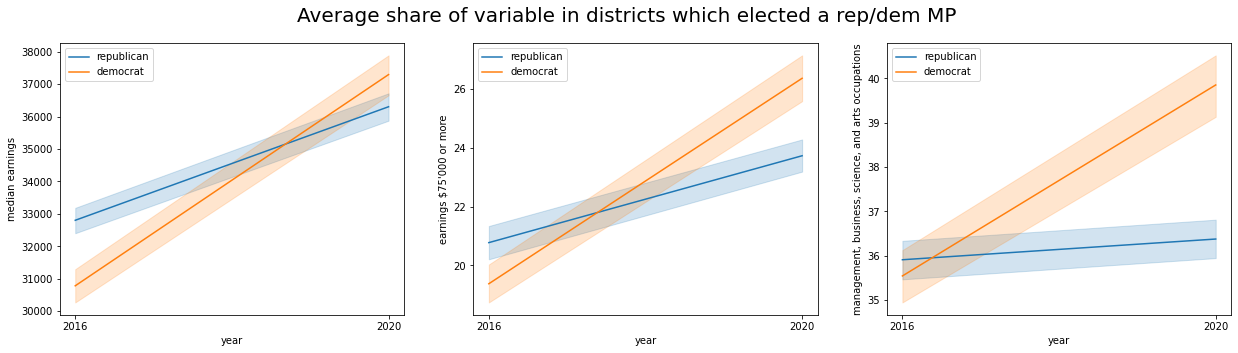

In [ ]:
fig, [ax0, ax1, ax2] = plt.subplots(nrows=1,
                       ncols=3,
                       figsize=(21, 5))
plt.suptitle("Average share of variable in districts which elected a rep/dem MP", size=20)
sns.lineplot(x="year", y="median earnings", hue="target", data=train, ax=ax0)
ax0.set_xticks([2016, 2020])
ax0.legend(["republican", "democrat"])
ax0.legend(["republican", "democrat"])
sns.lineplot(x="year", y="earnings $75'000 or more", hue="target", data=train, ax=ax1)
ax1.set_xticks([2016, 2020])
ax1.legend(["republican", "democrat"])
sns.lineplot(x="year", y="management, business, science, and arts occupations", hue="target", data=train[train.target!=2], ax=ax2)
ax2.set_xticks([2016, 2020])
ax2.legend(["republican", "democrat"], loc="upper left");

This trend is also visible in variables like median earnings, earnings of $75'000 or higher or occupations of management, business, science and arts. We can therefore conclude that in 2020 democrats tend to have been elected more often in higher educated and wealthier districts than in 2016.

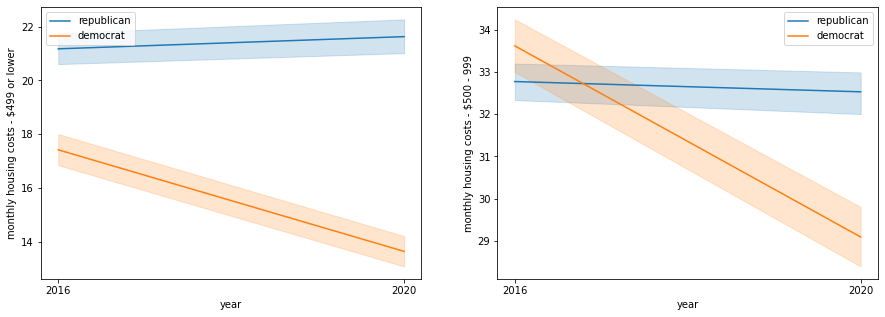

In [ ]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x="year", y="monthly housing costs - $499 or lower", hue="target", data=train, ax=ax0)
ax0.set_xticks([2016, 2020])
ax0.legend(["republican", "democrat"])
sns.lineplot(x="year", y="monthly housing costs - $500 - 999", hue="target", data=train, ax=ax1)
ax1.set_xticks([2016, 2020])
ax1.legend(["republican", "democrat"]);

In these plots we can see the average percentage of people with monthly housing costs (499 or lower and 500-999) in districts which voted for republicans or democrats. In both cases the percentage drops for democrats in 2020 and stays the same for districts which voted for republicans.  

There are two possible explanations for the development in these two variables: 
* Firstly, districts with higher educated and wealthier people could have voted for the democrats in 2020 more often.
* Secondly, districts where democrats got elected became wealthier over those 4 years. However, the latter would be a massive increase in earnings as well as education, which makes it a nearly impossible explanation.

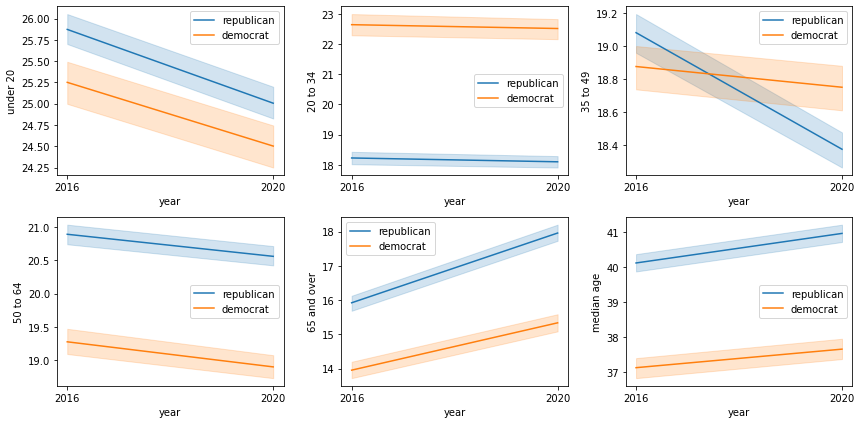

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
age_cols = ["under 20", "20 to 34", "35 to 49", "50 to 64", "65 and over", "median age"]
for num, (ax, col) in enumerate(zip(axes.flatten(), age_cols)):
  sns.lineplot(x="year", y=col, hue="target", data=train, ax=ax)
  ax.set_xticks([2016, 2020])
  ax.legend(["republican", "democrat"])
plt.tight_layout()

In the age variables we can see another interesting trend. Although the trend between 2016 and 2020 is negative for all the cohorts except the "65 and over" the median age for both parties seems to have risen.

Possible explanations: 
* Maybe it's because of the splitting, i.e. lots of the "younger districts" from 2020 are in the test set.
* Population got older as a whole.

Furthermore, districts which elected a republican candidate to the State House of Representatives tended to have a higher share of older age cohorts.

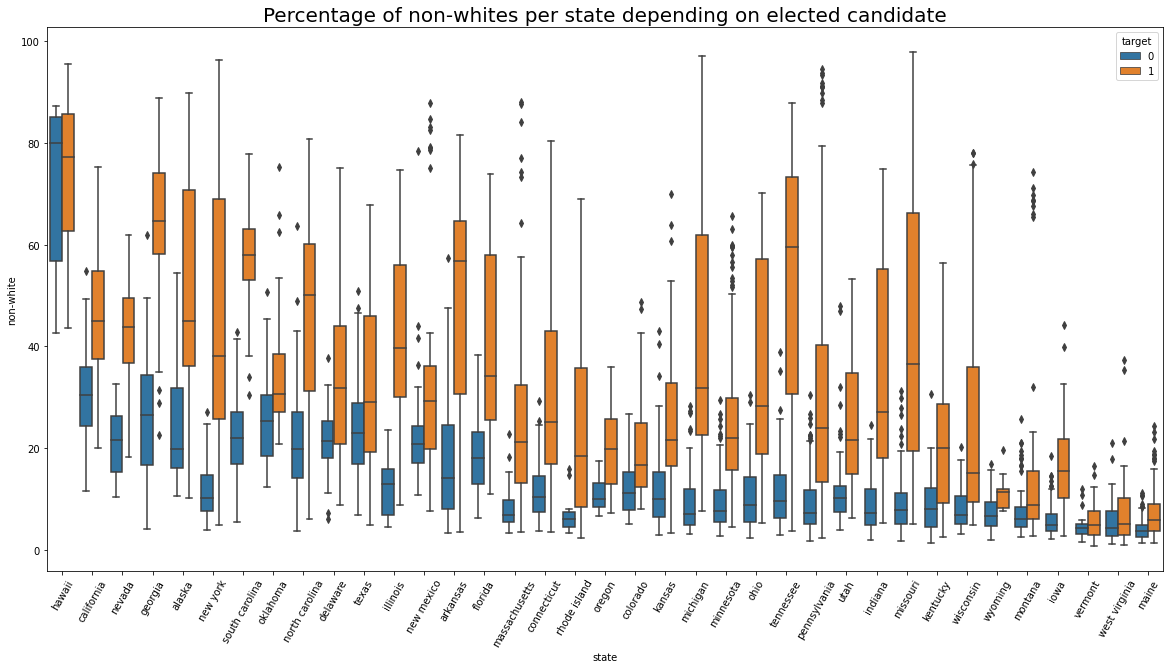

In [ ]:
# Percentage of Foreign Borns per state
order_median_fb = train.groupby("state")["non-white"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="non-white", hue="target", data=train, order=order_median_fb)
plt.title("Percentage of non-whites per state depending on elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

Districts with a higher share of foreign borns tend to more often vote for democrats. Same is also visible for share of non-white per district.

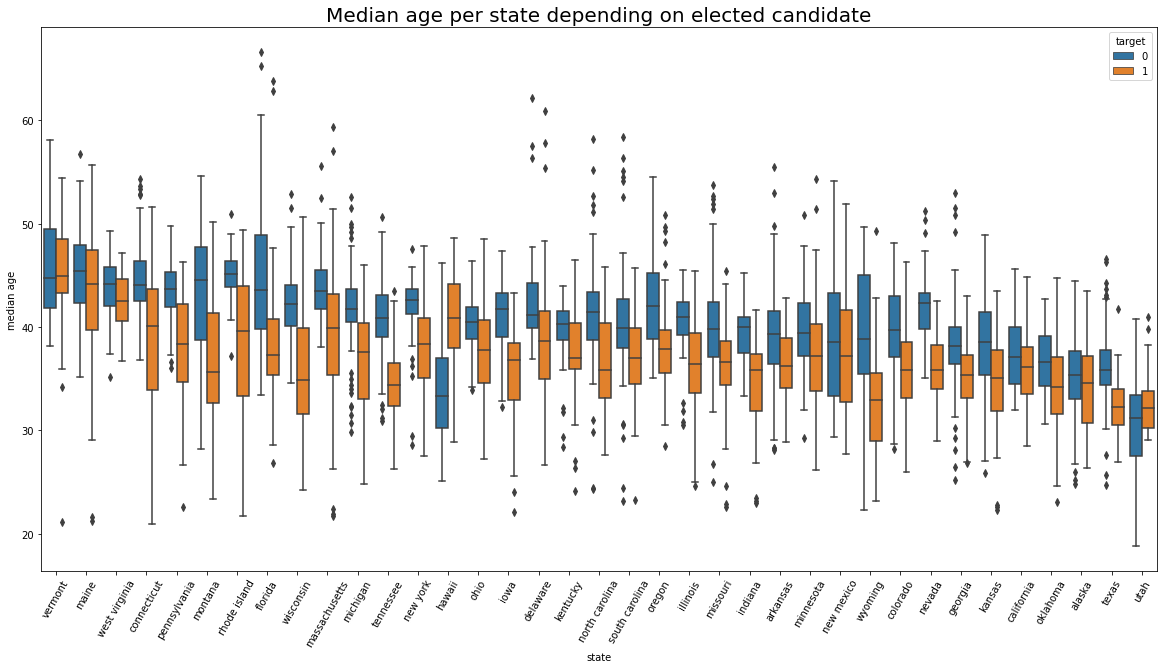

In [ ]:
order_median_nw = train.groupby("state")["median age"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="median age", hue="target", data=train, order=order_median_nw)
plt.title("Median age per state depending on elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

This graph confirms that in almost all states the average median age per state is higher for district which elected a republican member.

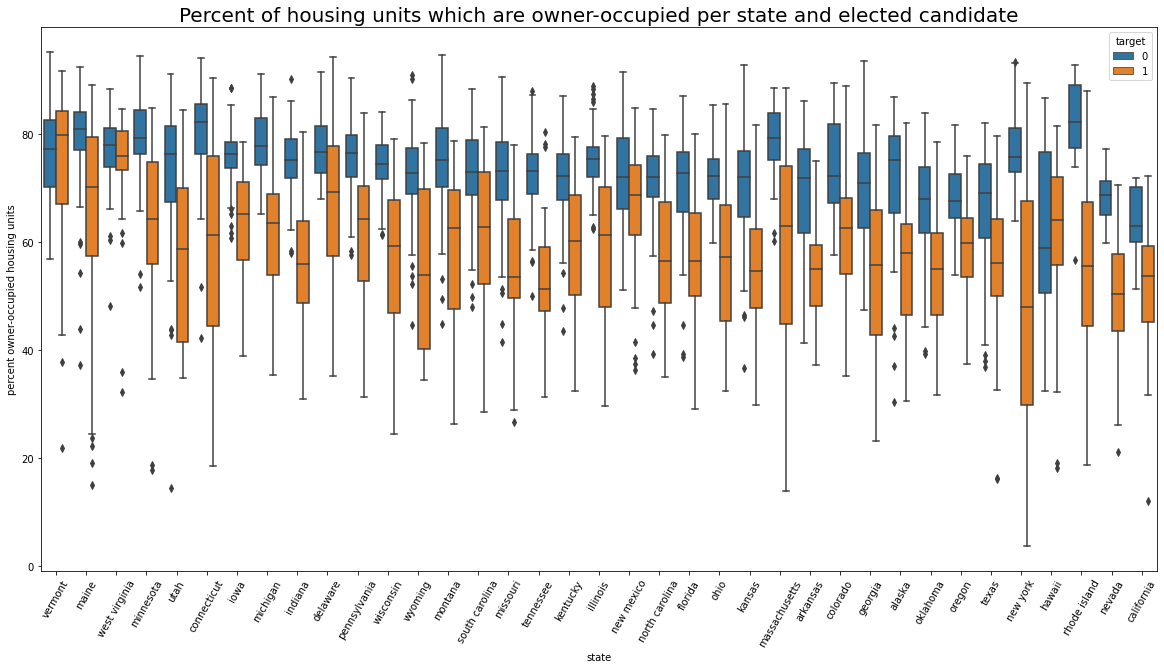

In [ ]:
order_median_nw = train.groupby("state")["percent owner-occupied housing units"].median().sort_values(ascending=False).index
plt.figure(figsize=(20, 10))
sns.boxplot(x="state", y="percent owner-occupied housing units", hue="target", data=train, order=order_median_nw)
plt.title("Percent of housing units which are owner-occupied per state and elected candidate", fontdict={"fontsize": 20})
plt.xticks(rotation=60);

Discricts with high share of owner-occupied housing units tend to more often elect republican candidates.

# Baseline Models

Preparations:
* impute missing values
* encode categoricals

In [ ]:
# Impute missing values
df_train = train.copy()
df_train["monthly housing costs - median"] = df_train["monthly housing costs - median"].fillna(df_train["monthly housing costs - median"].median())

In [ ]:
# Categorical encoding
from pandas.core.dtypes.dtypes import CategoricalDtype
df_train["district"] = df_train["district"].astype("category").cat.codes
df_train["state"] = df_train["state"].astype("category").cat.codes

In [ ]:
X = df_train.drop("target", axis=1)
y = df_train.target

In [ ]:
def get_baselines(X, y, list_of_models):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=22)
  results = pd.DataFrame()
  preds_total, probas = {}, {}
  for num, model in enumerate(list_of_models):
    print(model)
    results.loc[num, "feature"] = str(model)

    if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
      model = Pipeline(steps=[("standardizer", StandardScaler()), ("model", model)])
    
    # Cross validation scores
    scores = cross_val_score(model, 
                             X,
                             y,
                             cv=cv,
                             scoring="accuracy", 
                             n_jobs=-1)
    results.loc[num, "mean"] = np.mean(scores)
    results.loc[num, "std"] = np.std(scores)
    results.loc[num, [f"fold_{i}" for i in range(cv.get_n_splits())]] = scores
    
    # Cross validation predictions
    preds_proba = cross_val_predict(model,
                                    X,
                                    y,
                                    cv=10,
                                    method="predict_proba",
                                    n_jobs=-1)
    preds = np.argmax(preds_proba, axis=1).tolist()

    if isinstance(model, Pipeline):
      model = model.named_steps["model"]
    probas[str(model)] = preds_proba
    preds_total[str(model)] = preds
  return results, preds_total, probas

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(probability=True), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), 
                  CatBoostClassifier()]

In [ ]:
%%time
baseline_results, baseline_preds, baseline_probas = get_baselines(X, y, list_of_models)

LogisticRegression()
KNeighborsClassifier()
SVC(probability=True)
RandomForestClassifier()
XGBClassifier()
LGBMClassifier()
HistGradientBoostingClassifier()
CPU times: user 6.86 s, sys: 607 ms, total: 7.46 s
Wall time: 16min 10s


In [ ]:
baseline_results

,feature,mean,std,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,fold_11,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,fold_21,fold_22,fold_23,fold_24,fold_25,fold_26,fold_27,fold_28,fold_29
0,LogisticRegression(),0.837716,0.013750,0.851852,0.827160,0.834215,0.835979,0.818342,0.835689,0.823322,0.853357,0.848057,0.846290,0.837743,0.828924,0.858907,0.827160,0.851852,0.855124,0.818021,0.840989,0.823322,0.830389,0.860670,0.843034,0.837743,0.827160,0.846561,0.837456,0.832155,0.803887,0.833922,0.862191
1,KNeighborsClassifier(),0.843305,0.012572,0.827160,0.839506,0.867725,0.825397,0.832451,0.853357,0.833922,0.835689,0.844523,0.856890,0.853616,0.844797,0.850088,0.837743,0.865961,0.830389,0.835689,0.849823,0.837456,0.814488,0.843034,0.850088,0.825397,0.860670,0.853616,0.844523,0.844523,0.839223,0.839223,0.862191
2,SVC(probability=True),0.865723,0.014738,0.867725,0.862434,0.874780,0.844797,0.858907,0.881625,0.842756,0.881625,0.874558,0.867491,0.860670,0.858907,0.871252,0.862434,0.899471,0.872792,0.849823,0.878092,0.849823,0.842756,0.881834,0.874780,0.862434,0.881834,0.865961,0.881625,0.860424,0.830389,0.855124,0.874558
3,RandomForestClassifier(),0.858484,0.012907,0.848325,0.864198,0.880071,0.850088,0.858907,0.872792,0.837456,0.862191,0.863958,0.849823,0.862434,0.853616,0.871252,0.860670,0.871252,0.869258,0.848057,0.865724,0.842756,0.839223,0.881834,0.876543,0.851852,0.858907,0.857143,0.867491,0.856890,0.828622,0.839223,0.863958
4,XGBClassifier(),0.852541,0.014419,0.853616,0.851852,0.851852,0.839506,0.862434,0.858657,0.832155,0.862191,0.855124,0.860424,0.864198,0.844797,0.873016,0.839506,0.874780,0.860424,0.842756,0.863958,0.816254,0.842756,0.876543,0.864198,0.835979,0.857143,0.857143,0.856890,0.863958,0.837456,0.821555,0.855124
5,LGBMClassifier(),0.869840,0.012269,0.865961,0.867725,0.867725,0.865961,0.873016,0.874558,0.851590,0.890459,0.867491,0.871025,0.867725,0.869489,0.895944,0.880071,0.887125,0.874558,0.867491,0.869258,0.848057,0.848057,0.892416,0.874780,0.860670,0.880071,0.874780,0.863958,0.871025,0.851590,0.848057,0.874558
6,HistGradientBoostingClassifier(),0.870723,0.014606,0.876543,0.864198,0.867725,0.874780,0.865961,0.871025,0.863958,0.893993,0.869258,0.851590,0.869489,0.858907,0.883598,0.874780,0.910053,0.865724,0.871025,0.883392,0.860424,0.840989,0.899471,0.873016,0.853616,0.878307,0.869489,0.885159,0.865724,0.851590,0.849823,0.878092
7,<catboost.core.CatBoostClassifier object at 0x...,0.871724,0.012902,0.873016,0.873016,0.874780,0.858907,0.865961,0.876325,0.853357,0.886926,0.865724,0.860424,0.873016,0.858907,0.887125,0.880071,0.899471,0.883392,0.863958,0.879859,0.856890,0.849823,0.899471,0.876543,0.869489,0.871252,0.869489,0.885159,0.881625,0.851590,0.853357,0.872792


In [ ]:
baseline_results.to_csv("drive/MyDrive/US Elections/Notebook Data/baseline_results.csv", index=False)

In [ ]:
baseline_results = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/baseline_results.csv")

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/baseline_preds.pickle', 'wb') as baseline_preds_:
    pickle.dump(baseline_preds, baseline_preds_)
with open('drive/MyDrive/US Elections/Notebook Data/baseline_probas.pickle', 'wb') as baseline_probas_:
    pickle.dump(baseline_probas, baseline_probas_)

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/baseline_preds.pickle', 'rb') as baseline_preds_:
    baseline_preds = pickle.load(baseline_preds_)

with open('drive/MyDrive/US Elections/Notebook Data/baseline_probas.pickle', 'rb') as baseline_probas_:
    baseline_probas = pickle.load(baseline_probas_)

In [ ]:
from sklearn.metrics import classification_report

for model, preds in baseline_preds.items():
  print(model)
  print(classification_report(y, preds))
  print()
  print()

LogisticRegression()
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      3071
           1       0.85      0.78      0.81      2594

    accuracy                           0.84      5665
   macro avg       0.84      0.83      0.83      5665
weighted avg       0.84      0.84      0.84      5665



KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      3071
           1       0.88      0.76      0.82      2594

    accuracy                           0.84      5665
   macro avg       0.85      0.84      0.84      5665
weighted avg       0.85      0.84      0.84      5665



SVC(probability=True)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3071
           1       0.87      0.82      0.85      2594

    accuracy                           0.86      5665
   macro avg       0.87      0.86      0.86      5665
weig

For all models recall is higher than precision for the republicans and the opposite, precision is higher than recall, for the democrats. 

This actually makes totally sense as there are slightly more instances of republicans in the training set and the model tends to predict classes with more instances more often. Therefore the recall is higher than precision for republicans and lower for democrats.

# Model Evaluation

The goal of this part is to evaluate the models. Look at different visualizations and eventually look at what errors they made in particular.

## Confusion Matrix, ROC Curve, Precision-Recall Curve

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, dict_of_preds):
  # Create figure and subplots
  fig, ax = plt.subplots(8, 4, figsize=(20, 40))
  plt.suptitle("Confusion Matrices")
  # Loop over all predictions
  for num, (model, preds) in enumerate(dict_of_preds.items()):
    if num == 6:
      model = "HistGradBoostClf()"
    elif num == 7:
      model = "CatBoostClassifier()"
    ConfusionMatrixDisplay.from_predictions(y_true, preds, ax=ax[num, 0], colorbar=False)
    ax[num, 0].set_title(f"{str(model)} normal")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="pred", ax=ax[num, 1], colorbar=False)
    ax[num, 1].set_title(f"{str(model)} normalized predicted")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="true", ax=ax[num, 2], colorbar=False)
    ax[num, 2].set_title(f"{str(model)} normalized true")

    ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize="all", ax=ax[num, 3], colorbar=False)
    ax[num, 3].set_title(f"{str(model)} normalized all")
  plt.tight_layout()
  plt.show();

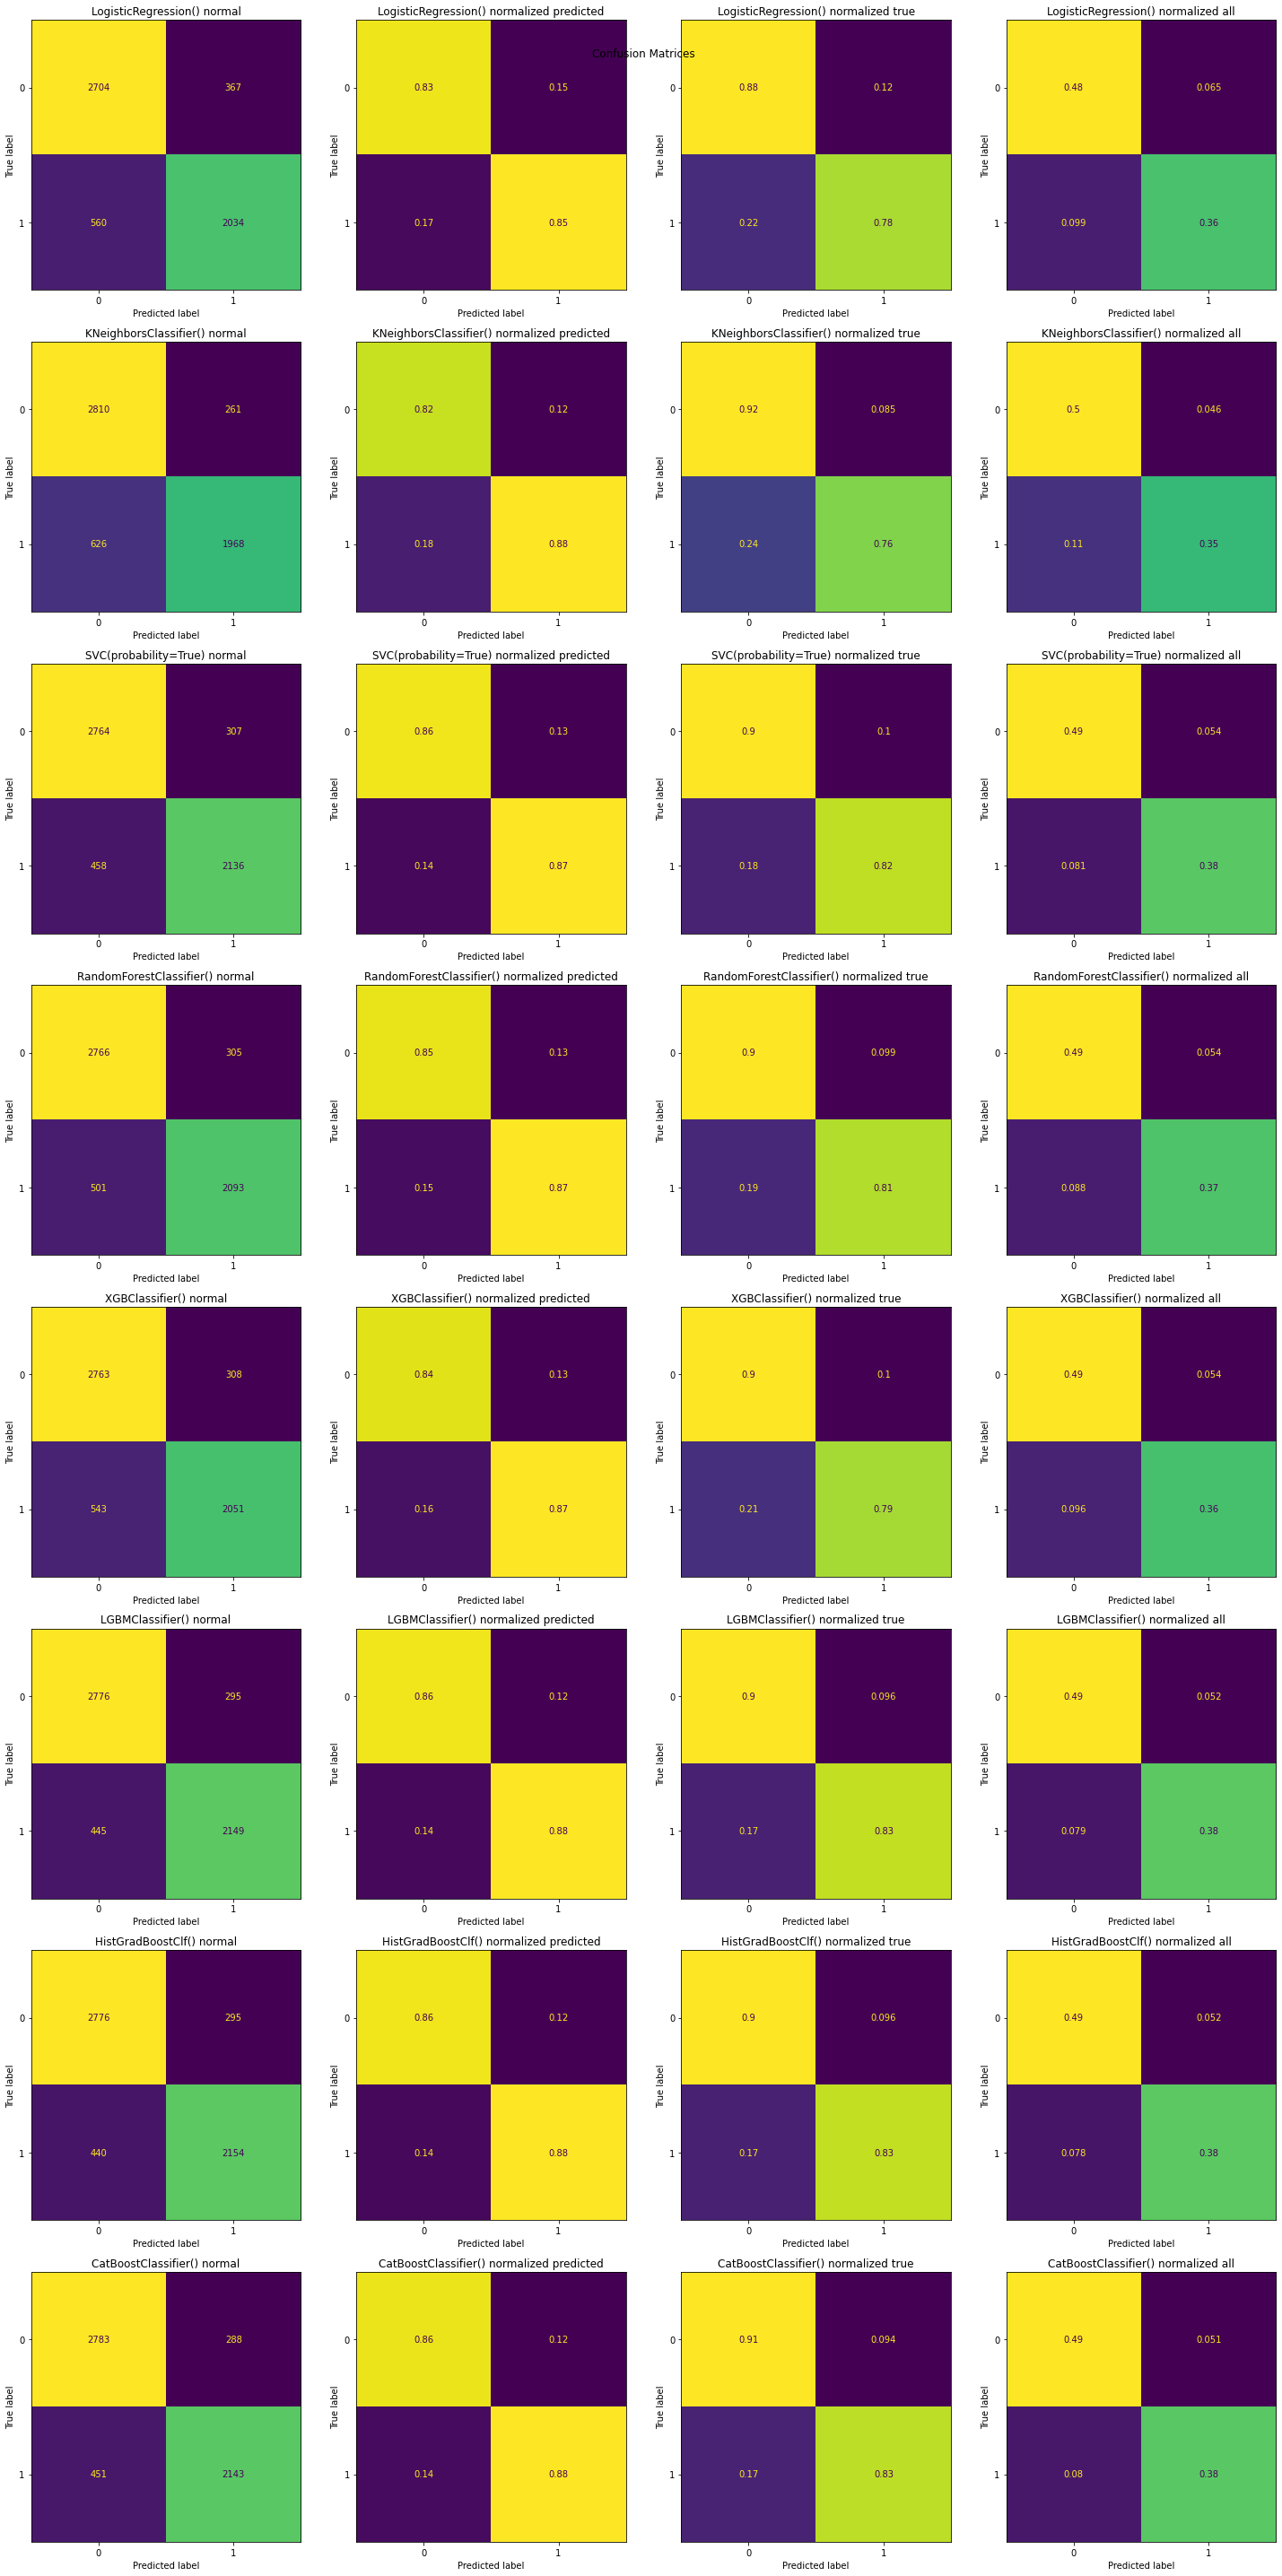

In [ ]:
plot_confusion_matrix(y, baseline_preds)

* The confusion matrices in the ***first column*** show the absolute number of predictions for all the models.
* The ***second column*** shows the matrices normalized by the label predicted. For democratic predictions the success rate was higher than for republicans. As the target variable counts more republican entries than democratic the models tend to predict republican more often.
* The ***third column*** shows the matrices normalized by the label true. Here the plots show that democratic districts are approx. twice as much wrongly classified as republican districts (~9-10% vs. ~17-20%). This means our model is worse in predicting democratic districts than predicting republican districts.
* The ***fourth column*** shows the matrices normalized over all instances. There are approx. 5% false positives, i.e. predicted as democrats, but actual republicans, and approx. 8% false negatives, i.e. predicted republicans, but actual democrats.

In [ ]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curves(y_true, dict_of_probas):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    RocCurveDisplay.from_predictions(y, pd.Series(probas[:, 1]), ax=ax)
    plt.title(model)
  plt.tight_layout()
  plt.show();

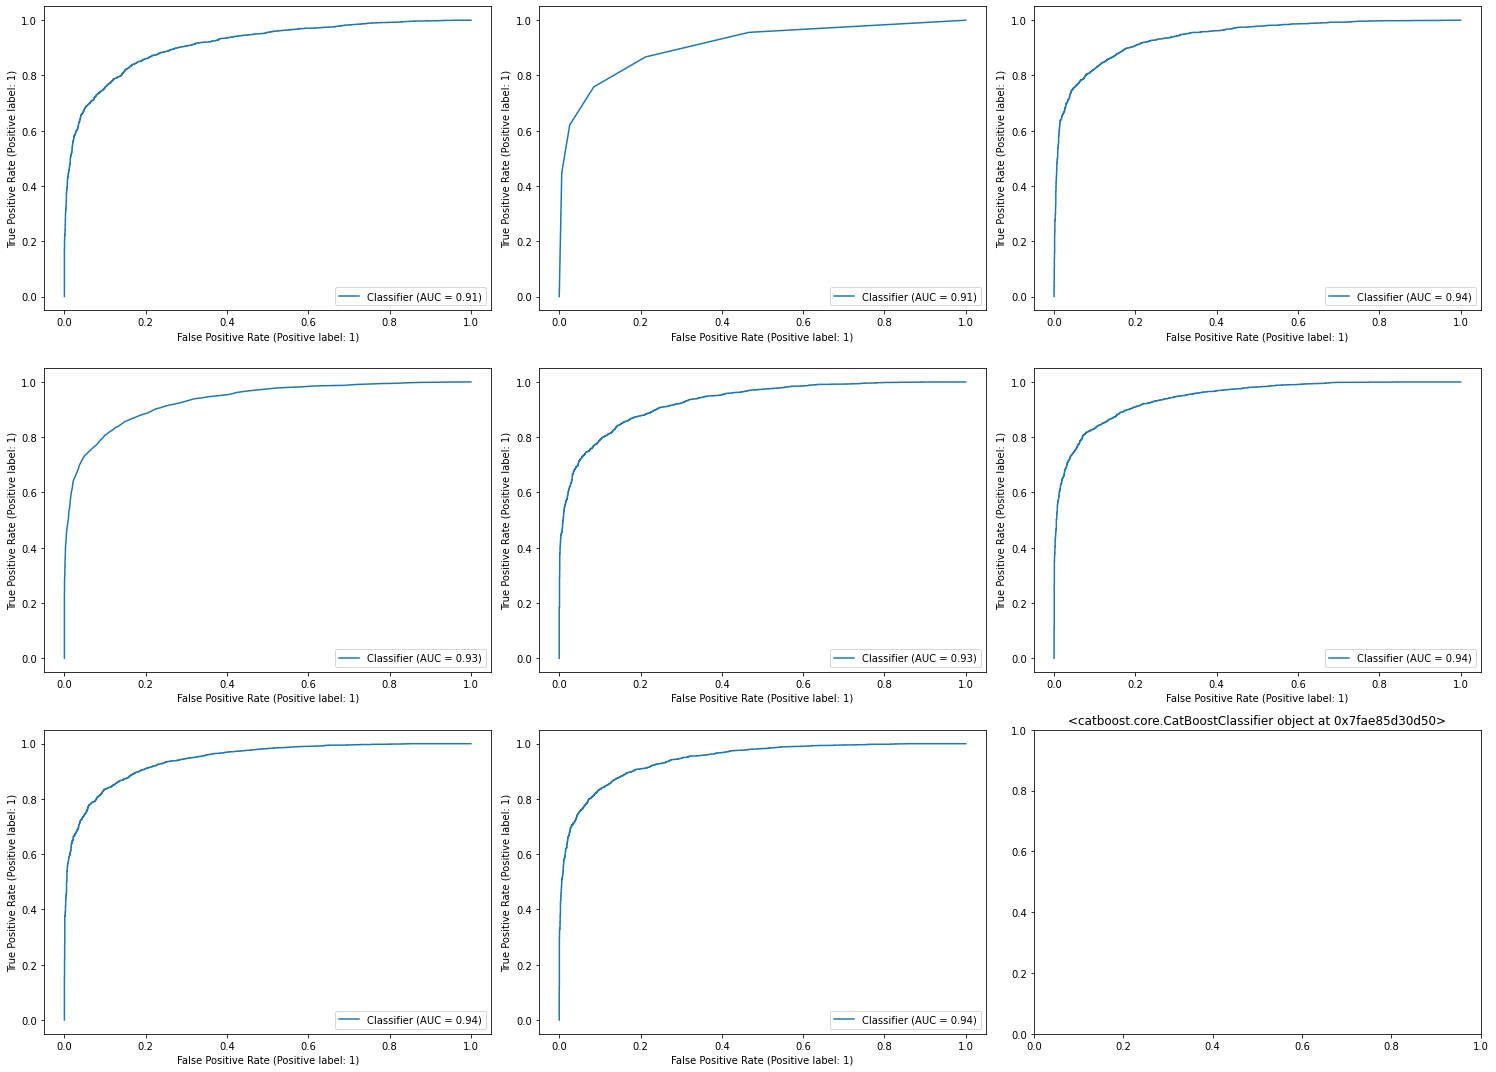

In [ ]:
plot_roc_curves(y, baseline_probas)

We can see that all the models have very similar ROC and precision-recall curves.

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

def plot_precision_recall_curves(y, dict_of_probas):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    PrecisionRecallDisplay.from_predictions(y, probas[:, 1], ax=ax)
    plt.title(model)
  plt.tight_layout()
  plt.show();

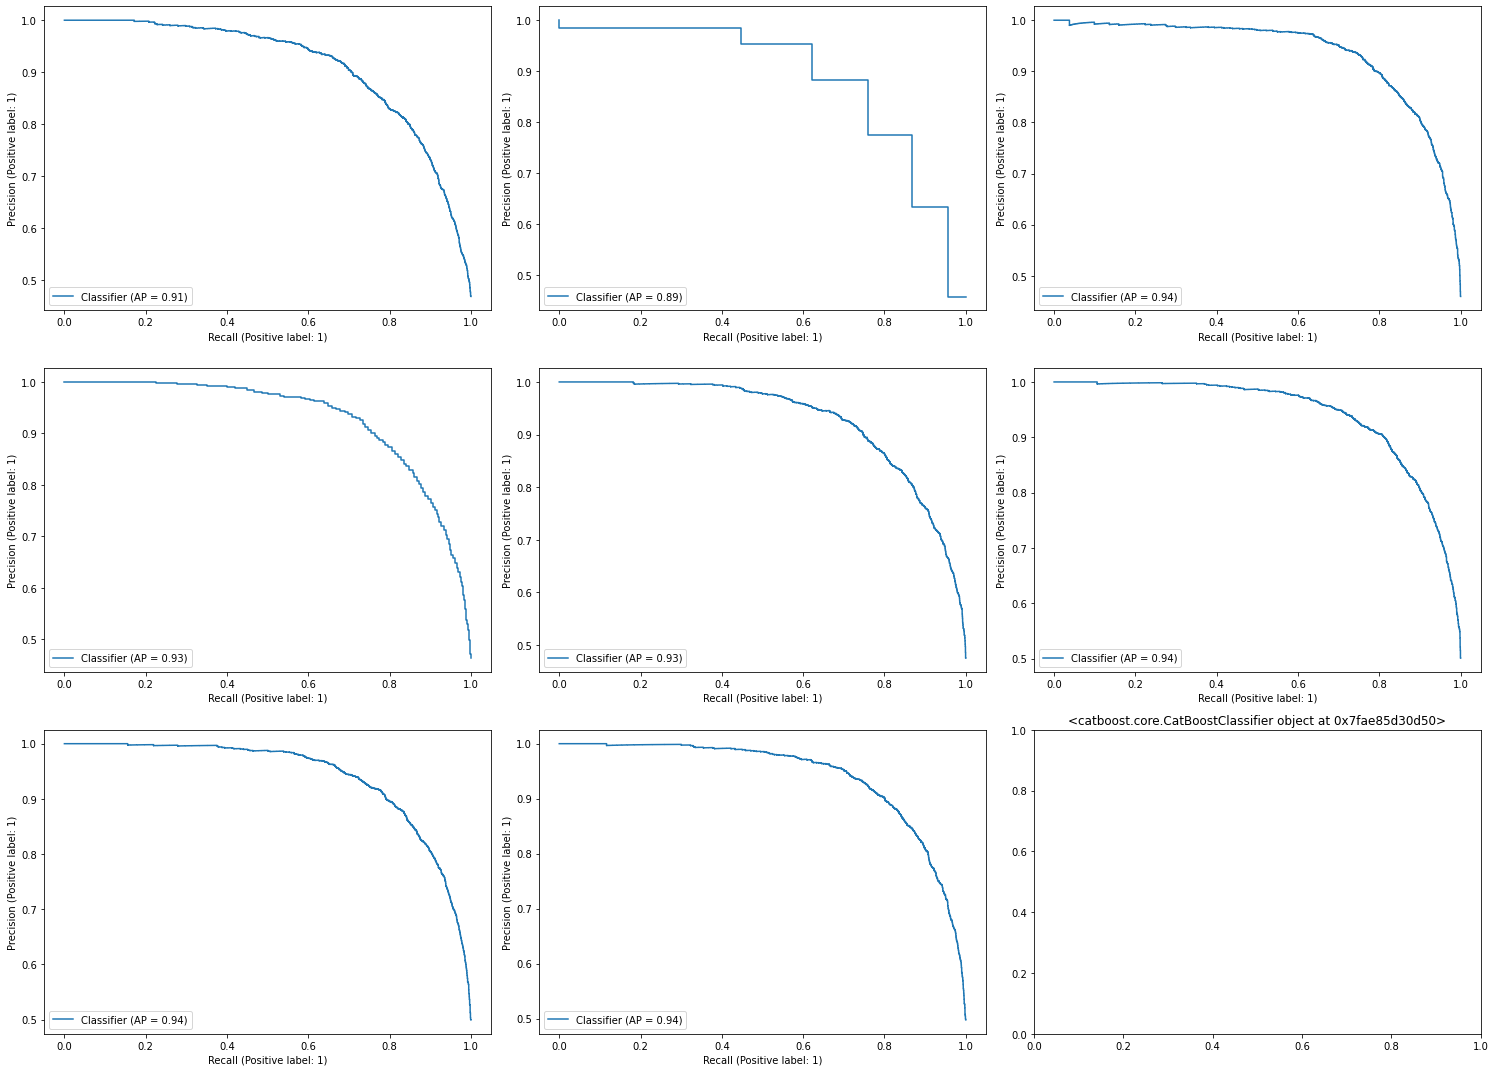

In [ ]:
plot_precision_recall_curves(y, baseline_probas)

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(X, y, list_of_models, cv=10):
  # Create figure and subplots
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  # Loop over all axes and models
  for num, (ax, model) in enumerate(zip(axes.flatten(), list_of_models)):
    # Calculate learning curve losses
    sizes, train_losses, val_losses = learning_curve(model, 
                                                     X, 
                                                     y,
                                                     train_sizes=[15, 50, 200, 700, 1400, 2100, 2800, 3500, 4300, 5098],
                                                     #train_sizes=np.linspace(20, 5098, cv) / 5098, 
                                                     cv=cv,
                                                     scoring="neg_log_loss",
                                                     n_jobs=1,
                                                     verbose=True)
    if num == 7:
      model = "CatBoostClassifier()"
    # Change to positive numbers and take mean
    train_loss = -np.mean(train_losses, axis=1)
    val_loss = -np.mean(val_losses, axis=1)
    # Plot the learning curves
    sns.lineplot(x=sizes, y=train_loss, ax=ax)
    sns.lineplot(x=sizes, y=val_loss, ax=ax)
    ax.set_title(model)
    ax.legend(["train", "validation"])
  plt.tight_layout()
  plt.show();

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(probability=True), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), 
                  CatBoostClassifier()]

In [ ]:
plot_learning_curves(X, y, list_of_models)

These plots show the learning curves of all the models. While the Logistic Regression and the SVC seem already quite at the limit, most of the other models show much room for improvement and are overfitting.

## Error Analysis



### Most wrong predictions

Instances which 6, 7 or all 8 models predicted wrongly.

In [ ]:
def get_error_indices(X, y, dict_of_preds):
  error_instances = []
  for model, preds in baseline_preds.items():
    print(model)
    errors = y != preds
    idx = X.iloc[np.where(errors)[0], :].index.tolist()
    error_instances.extend(idx)
  errors_sorted = np.unique(error_instances, return_counts=True)[0]
  error_counts = np.unique(error_instances, return_counts=True)[1]
  list_of_errors = sorted(list(zip(error_counts, errors_sorted)), reverse=True)
  list_of_error_counts = sorted(list(zip(np.unique(error_counts, return_counts=True)[0], np.unique(error_counts, return_counts=True)[1])))
  return list_of_errors, list_of_error_counts

In [ ]:
list_of_errors, list_of_error_counts = get_error_indices(X, y, baseline_preds)

LogisticRegression()
KNeighborsClassifier()
SVC(probability=True)
RandomForestClassifier()
XGBClassifier()
LGBMClassifier()
HistGradientBoostingClassifier()


In [ ]:
# Voting Classifier would make 773 mistakes, which results in a performance of 86.35% accuracy.
list_of_error_counts

[(1, 439), (2, 182), (3, 118), (4, 102), (5, 93), (6, 103), (7, 174), (8, 323)]

In [ ]:
indices = []
for error_idx in list_of_errors:
  if error_idx[0] > 5:
    indices.append(error_idx[1])

In [ ]:
# DataFrame with instances which got 6 or 7 times wrongly predicted out of 7 models
most_wrong_df = train.loc[indices, :]
most_wrong_df.head()

,district,percent households receiving food stamps,state,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,year,target
7566,46,2.8,wyoming,7.1,8.4,9.55,2.28,44.96,16.78,29.51,16.89,17.18,19.63,38.4,20.54,30.27,35.04,14.15,988.0,63.8,2.65,5.37,14.1,54.67,11.05,16.49,17.79,11.28,36.02,28.71,23.99,31605,2.68,14.31,32.57,50.45,2020,0
7559,39,5.3,wyoming,13.0,16.4,9.95,1.13,46.94,30.55,18.33,21.85,20.13,9.14,35.5,28.29,29.31,32.90,9.50,858.0,68.9,3.06,11.14,14.4,27.44,16.01,19.23,37.32,10.93,26.45,24.68,37.94,39821,8.76,33.11,37.50,20.63,2020,1
7537,17,9.6,wyoming,18.2,15.8,11.32,1.70,44.96,24.97,21.95,22.51,17.84,12.73,36.3,34.50,37.34,23.82,4.34,701.0,78.3,3.49,10.11,14.3,23.03,15.26,19.66,42.05,14.01,30.81,27.92,27.26,33472,13.58,34.88,37.77,13.77,2020,1
7534,14,0.3,wyoming,5.8,7.0,11.82,1.82,49.79,33.12,35.58,12.24,9.53,9.52,23.2,17.19,34.62,34.33,13.85,937.0,50.3,3.29,7.43,18.1,53.71,13.32,17.25,15.71,17.71,34.08,23.69,24.52,15966,1.38,12.47,43.13,43.02,2020,1
7502,81,10.5,wisconsin,4.0,5.2,7.53,1.47,50.20,23.19,17.93,19.16,21.73,18.00,41.6,13.12,40.43,36.12,10.33,949.0,69.5,2.87,3.67,8.9,35.18,18.61,19.58,26.63,11.20,39.78,28.78,20.24,37123,8.42,33.71,34.61,23.26,2020,1


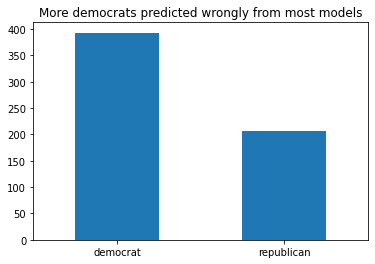

In [ ]:
most_wrong_df.target.value_counts().plot.bar()
plt.title("More democrats predicted wrongly from most models")
plt.xticks([0, 1],["democrat", "republican"], rotation=0);

Twice as many Democrats as Republicans appear in the most_wrong predictions. This actually makes sense as the target is slightly imbalanced and models tend to be better on more data (-> more instances of republicans than democrats).

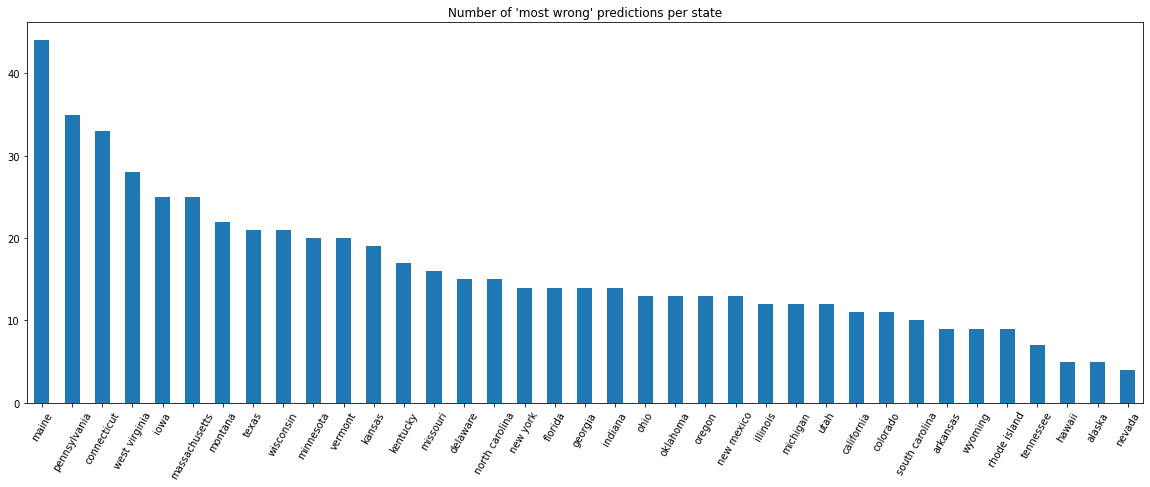

In [ ]:
plt.figure(figsize=(20, 7))
state_idx = most_wrong_df.state.value_counts().index
most_wrong_df.state.value_counts().plot.bar()
plt.title("Number of 'most wrong' predictions per state")
plt.xticks(np.arange(len(state_idx)), state_idx, rotation=60);

In [ ]:
def republican_percentage(X, y):
  """Returns percentage of republican and democratic elects per district."""
  df = pd.concat([X, y], axis=1)
  perc_elected = []
  for state, _ in enumerate(df.state.unique()):
  #for state in range(3):
    for i in range(2):
      perc_elected.append(df[(df.state == state) & (df.target == i)].shape[0] / df[df.state == state].shape[0])
  perc_rep, perc_dem = perc_elected[::2], perc_elected[1::2]
  return perc_rep, perc_dem

In [ ]:
perc_rep, perc_dem = republican_percentage(X, y)

In [ ]:
# Get sorted list of states
states = sorted(train.state.unique())
sorted_list = sorted(list(zip(perc_rep, states)), reverse=True)
sorted_perc_rep, sorted_states = [], []
for state in sorted_list:
  sorted_perc_rep.append(state[0])
  sorted_states.append(state[1])

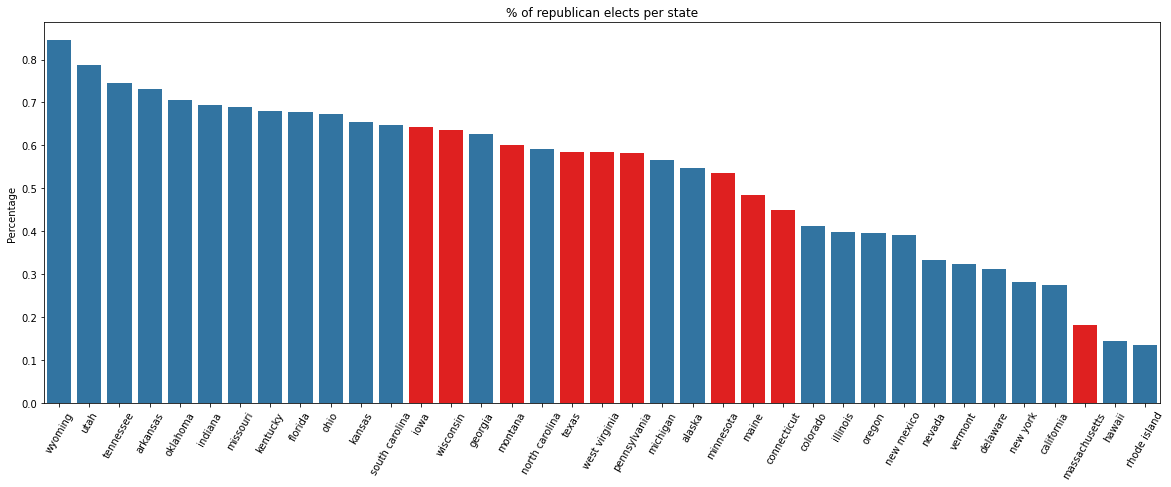

In [ ]:
plt.figure(figsize=(20, 7))
#plt.bar(sorted_states, sorted_perc_rep)
sns.barplot(x=sorted_states, y=sorted_perc_rep, palette=["#1f77b4" if state not in most_wrong_df.state.value_counts().index[:10] else "red" for state in sorted_states])
plt.title("% of republican elects per state")
plt.ylabel("Percentage")
plt.xticks(rotation=60);

Red coloured are the ten states with the most instances in the most_wrong predicted DataFrame. As we can see, they tend to be in the middle of the distribution. So the more balanced the target variable in a state the more error prone it is for a model.

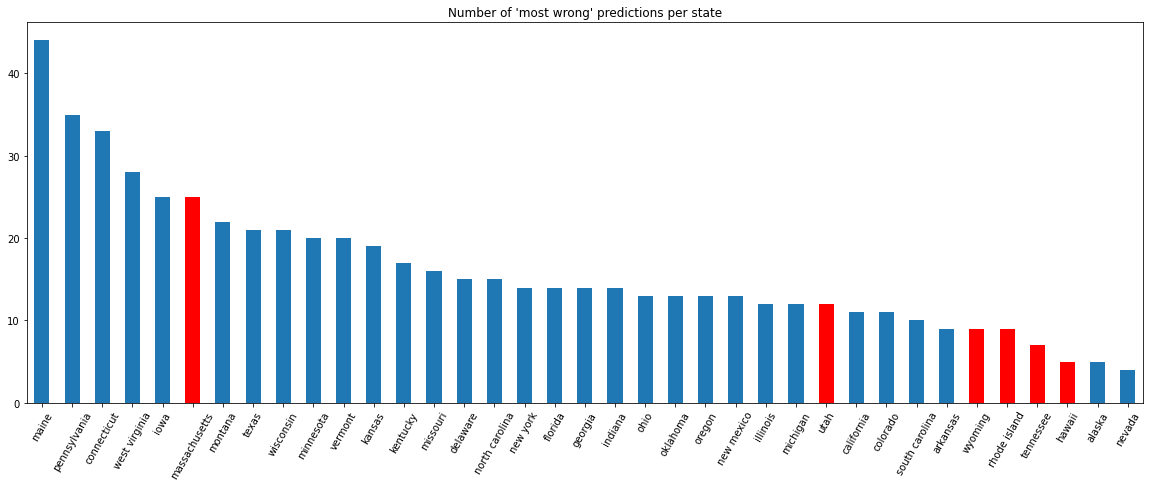

In [ ]:
plt.figure(figsize=(20, 7))
state_idx = most_wrong_df.state.value_counts().index
most_wrong_df.state.value_counts().plot.bar(color=["#1f77b4" if state not in [*sorted_states[:3], *sorted_states[-3:]] else "red" for state in most_wrong_df.state.value_counts().index])
plt.title("Number of 'most wrong' predictions per state")
plt.xticks(np.arange(len(state_idx)), state_idx, rotation=60);

In contrast, states with a highly imbalanced target variable (red) tend to have a lower susceptibility to errors.

### Residual Analysis

In [ ]:
def pearson_residuals(target, pred_probas):
  residuals = (target - pred_probas) / np.sqrt(pred_probas * (1 - pred_probas))
  return residuals

In [ ]:
def plot_residuals(y, dict_of_probas):
  fig, axes = plt.subplots(3, 3, figsize=(21, 15))
  for ax, (model, probas) in zip(axes.flatten(), dict_of_probas.items()):
    residuals = pearson_residuals(y, probas[:, 1])
    sns.histplot(x=residuals, ax=ax)
    ax.set_title(f"{model} Pearson Residuals")
  plt.tight_layout()
  plt.show();

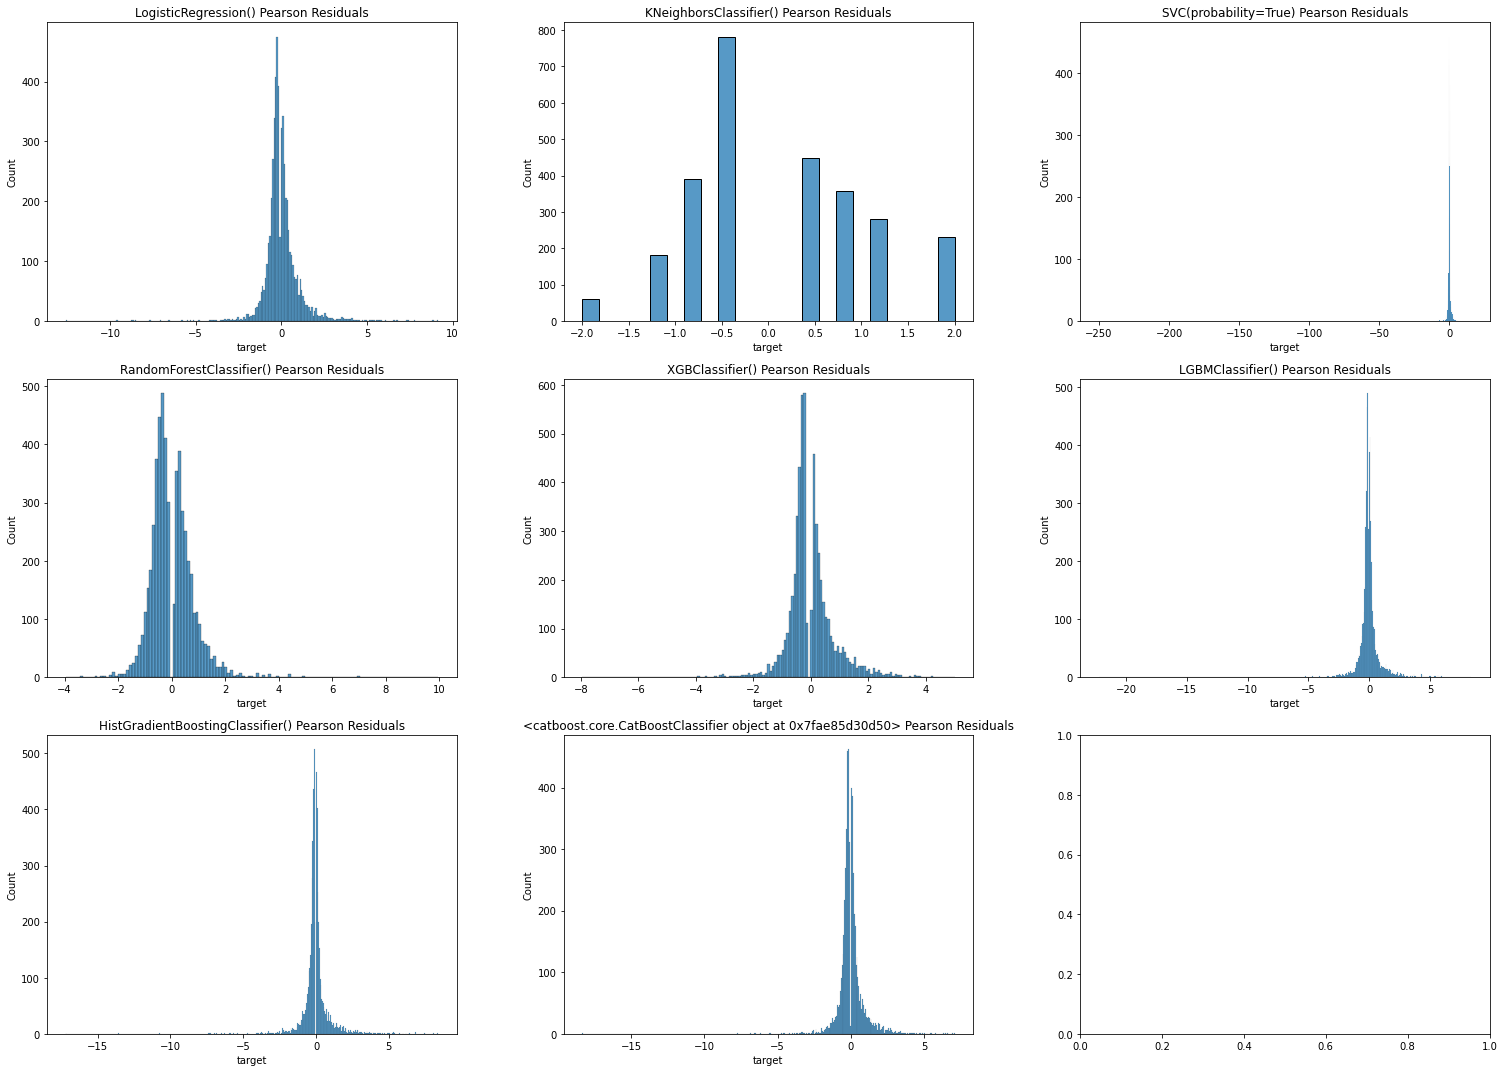

In [ ]:
plot_residuals(y, baseline_probas)

### Highest Error Predictions

Instances which have a very high residual error. E.g. instances which have been predicted as democrats with a 80% probability but are actually republicans and vice versa.

In [ ]:
high_error_idx = []
for model, probas in baseline_probas.items():
  residuals = pearson_residuals(y, probas[:, 1])
  idx = sorted(residuals.loc[(residuals > pearson_residuals(1, 0.1)) | (residuals < pearson_residuals(0, 0.9))].index.tolist())
  high_error_idx.extend(idx)
  high_error_idx = list(set(high_error_idx))

In [ ]:
# Get indices of rows which are in high_error and most_wrong DataFrames
high_error_df = df_train.loc[high_error_idx, :]
high_most_idx = [idx for idx in high_error_df.index if idx in most_wrong_df.index]

In [ ]:
X.loc[high_most_idx, :].head()

,district,percent households receiving food stamps,state,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,year
4099,367,5.4,3,9.8,8.6,13.03,0.70,49.69,21.06,20.02,18.19,21.58,19.15,42.0,21.27,22.70,41.04,14.99,1119.0,69.7,2.98,2.95,10.5,40.55,19.61,21.40,18.44,15.58,37.56,22.95,23.91,31804,4.68,21.71,32.93,40.69,2020
4102,387,21.2,3,10.3,22.7,19.38,0.73,49.64,25.99,17.73,17.38,19.65,19.26,40.0,34.08,39.31,23.97,2.64,683.0,64.3,3.15,6.08,21.5,31.38,20.63,20.54,27.44,21.85,45.22,19.65,13.28,25704,13.42,30.75,35.99,19.84,2020
4127,205,15.0,4,3.7,29.2,20.43,4.09,50.17,23.18,19.88,20.41,18.82,17.70,40.6,4.12,33.82,48.41,13.65,1211.0,64.3,2.99,14.82,13.2,34.97,15.99,23.04,26.00,10.80,28.37,33.17,27.66,43878,11.27,34.96,29.39,24.38,2020
33,266,3.6,0,12.2,8.9,28.89,1.06,50.57,26.50,20.60,19.70,23.50,9.80,36.7,8.10,17.20,40.60,33.60,1630.0,72.9,3.12,6.37,4.3,43.22,14.41,23.40,18.97,9.20,30.70,31.20,28.90,44199,4.62,24.52,37.99,32.87,2016
2091,251,12.4,19,20.7,3.7,5.25,0.35,46.98,22.90,16.10,19.70,25.10,16.30,43.4,30.30,32.40,32.90,1.90,770.0,70.2,2.94,1.54,20.4,31.30,21.89,20.15,26.67,26.10,49.50,14.60,9.80,24466,8.81,35.50,35.74,19.96,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6065,256,2.0,21,1.6,16.5,18.64,2.22,51.95,22.35,11.48,18.18,25.54,22.46,48.9,10.05,22.81,30.81,36.33,1512.0,84.1,2.96,11.50,4.4,68.92,7.72,17.40,5.96,4.84,16.83,18.53,59.80,64891,2.66,10.76,21.54,65.05,2020
6097,390,30.7,21,13.5,43.3,41.66,3.88,45.98,30.70,21.77,18.84,16.18,12.51,33.3,44.74,39.50,13.90,1.85,559.0,59.7,3.61,17.53,24.8,24.68,21.00,18.90,35.42,28.58,43.79,19.03,8.60,25289,29.05,32.60,30.02,8.34,2020
4065,217,1.6,3,2.9,5.0,7.94,0.77,49.26,21.69,13.53,21.21,25.45,18.11,46.3,7.22,17.73,31.38,43.67,1836.0,88.9,2.92,4.37,3.8,57.78,11.61,18.91,11.70,7.33,18.45,21.23,52.99,54744,2.76,13.91,26.07,57.26,2020
6116,43,4.2,22,2.4,16.6,15.54,5.17,51.29,22.82,16.41,18.20,25.09,17.49,45.0,0.77,6.47,32.85,59.91,2326.0,89.4,3.44,13.72,5.2,48.92,13.15,24.37,13.55,6.89,19.51,21.21,52.39,55022,5.58,21.90,26.75,45.77,2020


In [ ]:
high_error_df.describe()

,district,percent households receiving food stamps,state,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,year,target
count,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000,339.000000
mean,267.616519,11.439233,19.058997,8.981416,13.289086,16.952684,5.548378,51.029794,24.679174,19.480265,18.869705,20.606991,16.357581,40.077286,19.323923,31.403982,33.730324,14.195782,1067.887906,69.297050,3.099794,9.082212,12.560767,37.559617,17.232743,22.683127,22.524808,17.436254,36.899735,22.392006,23.271563,34597.793510,9.902979,29.397198,31.416932,29.283274,2017.604720,0.699115
std,150.434874,6.824986,10.090833,5.392070,15.249581,15.160807,7.922310,2.325856,3.632310,5.387089,2.543563,3.246500,4.461955,5.409523,13.369423,10.437260,11.717383,15.077979,456.910463,12.252626,0.269438,11.419001,6.539762,10.605977,3.863206,3.031506,8.319045,7.985229,8.638041,4.380662,13.393680,10086.739161,5.552792,9.208797,6.225335,14.361573,1.963447,0.459321
min,1.000000,0.300000,0.000000,0.700000,0.300000,1.630000,0.000000,38.610000,14.800000,9.000000,3.800000,3.100000,2.500000,21.700000,0.770000,2.040000,6.600000,0.000000,370.000000,14.400000,2.510000,0.160000,2.100000,12.430000,6.720000,12.040000,4.370000,3.210000,10.180000,7.890000,3.100000,7966.000000,0.880000,7.260000,13.010000,7.450000,2016.000000,0.000000
25%,137.000000,6.000000,12.000000,5.000000,4.200000,6.220000,0.990000,50.045000,22.375000,16.100000,17.410000,18.820000,13.385000,36.700000,8.100000,22.860000,24.850000,3.100000,738.000000,61.900000,2.920000,2.110000,7.350000,29.360000,14.870000,20.785000,16.515000,11.185000,31.675000,19.665000,13.085000,27352.500000,6.025000,23.465000,27.455000,18.320000,2016.000000,0.000000
50%,300.000000,10.300000,18.000000,7.700000,7.800000,11.680000,2.520000,51.180000,24.500000,18.460000,19.040000,21.000000,16.300000,40.800000,16.940000,33.400000,35.000000,7.600000,960.000000,71.400000,3.060000,5.240000,11.900000,35.790000,17.400000,22.750000,22.400000,16.490000,38.740000,22.600000,19.200000,32172.000000,8.700000,29.810000,31.400000,26.350000,2016.000000,1.000000
75%,399.000000,15.850000,27.500000,11.750000,16.400000,22.595000,6.820000,52.300000,26.800000,21.810000,20.375000,22.415000,18.965000,43.300000,27.550000,39.355000,41.900000,21.800000,1320.500000,78.650000,3.220000,11.670000,16.400000,44.200000,19.430000,24.495000,29.050000,23.070000,42.960000,25.440000,29.925000,40003.500000,13.100000,36.215000,35.160000,36.620000,2020.000000,1.000000
max,526.000000,41.900000,36.000000,30.400000,90.800000,87.270000,55.190000,59.750000,43.660000,67.100000,29.600000,29.300000,34.000000,58.100000,60.800000,59.620000,60.280000,79.630000,3680.000000,94.200000,4.270000,80.120000,46.100000,71.260000,28.090000,32.150000,52.640000,47.750000,54.920000,35.430000,77.460000,83590.000000,36.310000,48.990000,69.800000,73.160000,2020.000000,1.000000


### Most different Distribution of Variables

In [ ]:
X[df_train.target==0]

,district,percent households receiving food stamps,state,percent uninsured,household language not english,non-white,black/afroamerican,percent female,under 20,20 to 34,35 to 49,50 to 64,65 and over,median age,monthly housing costs - $499 or lower,monthly housing costs - $500 - 999,monthly housing costs - $1000 1999,monthly housing costs - $2000 or higher,monthly housing costs - median,percent owner-occupied housing units,average family size,foreign born,percent of tot. population in poverty,"management, business, science, and arts occupations",service occupations,sales and office occupations,blue collar occupations,earnings $1 - $24'999,earnings $25'000 - 49'999,earnings $50'000 - 74'999,earnings $75'000 or more,median earnings,less than highschool,highschool,college or associate,bachelor or higher,year
606,1,16.6,7,16.1,11.1,9.96,3.30,54.17,24.80,18.30,19.30,19.80,17.90,40.7,31.20,37.40,24.50,3.70,703.0,71.2,3.19,5.51,19.7,30.15,17.78,23.34,28.73,27.03,45.25,16.72,11.01,26258,19.52,33.51,30.02,16.96,2016
7278,362,5.4,32,7.4,12.4,9.16,0.40,48.06,35.47,23.87,18.20,12.52,9.94,28.0,13.05,16.42,56.12,14.40,1325.0,67.4,3.73,8.20,6.6,45.30,12.21,26.32,16.17,13.83,33.60,24.28,28.28,32547,4.02,20.17,40.66,35.15,2020
3664,251,5.1,35,3.5,5.7,6.26,0.99,50.69,27.80,16.90,21.40,21.60,12.30,38.7,12.20,37.30,42.40,7.30,1001.0,79.5,3.04,3.39,6.3,37.16,12.77,24.94,25.13,11.90,40.20,28.90,19.00,37490,6.31,31.30,33.41,28.98,2016
5919,225,6.0,19,6.4,6.4,7.03,0.13,50.40,26.24,13.41,18.93,21.83,19.60,43.0,36.74,31.89,25.74,5.63,628.0,73.4,3.08,2.12,9.5,38.79,17.23,16.01,27.97,19.80,38.01,20.04,22.14,32304,11.74,33.80,29.87,24.58,2020
3591,510,8.8,33,3.1,3.9,5.50,2.37,51.06,19.70,12.60,16.40,25.20,26.10,50.6,15.10,43.30,30.70,10.40,870.0,73.2,3.02,1.03,6.6,39.72,20.56,24.57,15.15,12.11,44.34,25.13,18.42,35404,8.78,25.71,30.08,35.43,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3702,303,14.5,35,8.2,6.7,5.65,1.79,49.84,21.10,16.20,17.10,23.50,22.10,46.8,24.80,43.20,25.70,3.90,752.0,72.3,2.87,3.83,12.0,25.89,19.60,21.10,33.41,23.50,44.70,21.40,10.40,26448,11.30,41.08,31.87,15.75,2016
556,438,14.6,6,22.7,39.5,16.16,8.48,51.21,26.30,17.90,18.00,17.80,19.90,39.7,19.40,31.30,34.00,12.90,971.0,69.9,3.42,24.81,17.8,28.00,20.69,22.63,28.69,25.27,40.86,18.38,15.48,25836,21.99,29.08,26.56,22.38,2016
2548,466,3.2,23,7.0,8.7,19.49,13.33,52.00,28.60,17.00,25.20,18.00,11.10,37.8,8.00,21.00,49.80,20.40,1352.0,70.9,3.09,7.41,4.6,52.11,12.09,26.54,9.26,9.00,27.70,21.40,41.90,46321,4.72,14.55,29.53,51.20,2016
6329,422,7.4,23,9.4,15.5,26.19,16.81,53.09,24.92,18.18,19.87,19.92,17.12,40.4,18.60,33.99,41.55,5.86,971.0,69.8,3.12,10.93,10.4,40.11,15.52,24.13,20.24,13.08,38.90,25.84,22.19,36934,9.61,25.05,33.76,31.58,2020


In [ ]:
def difference_to_normal_df(X, most_wrong_df):
  """ 
  Returns the difference of the means per feature of of X and most_wrong_df.
  The difference is measured using p-values from t-test.
  """
  p_values_0 = []
  p_values_1 = []
  for col in X.drop(["district", "state", "year"], axis=1).columns:
    _, p = ttest_ind(X[df_train.target==0][col], most_wrong_df[most_wrong_df.target==0][col])
    p_values_0.append(p)
    _, p = ttest_ind(X[df_train.target==1][col], most_wrong_df[most_wrong_df.target==1][col])
    p_values_1.append(p)
  p_values_0 = list(zip(p_values_0, X.drop(["district", "state", "year"], axis=1).columns))
  p_values_1 = list(zip(p_values_1, X.drop(["district", "state", "year"], axis=1).columns))
  return p_values_0, p_values_1

In [ ]:
diff_rep, diff_dem = difference_to_normal_df(X, most_wrong_df)

These are the columns of the most_wrong_df which are the most different to the the columns itself in the original DataFrame. This could mean that this columns tend to have a high influence on the wrong decisions of the models.

In [ ]:
# p_values with bonferroni correction 0.05 / 36 = 0.00138888888 and select the top few which appear in both target classes
sorted([pval for pval in diff_rep if pval[0] < 0.00138888888])[:8]

[(1.7389206774030994e-43, 'foreign born'),
 (1.776143710076368e-43, 'percent owner-occupied housing units'),
 (1.564702478130179e-39, 'household language not english'),
 (3.872067404591548e-35, 'non-white'),
 (4.055932223452721e-24, 'highschool'),
 (1.0744797176335284e-23, 'blue collar occupations'),
 (8.889239096054674e-23, 'bachelor or higher'),
 (1.2395677266311576e-22, '20 to 34')]

In [ ]:
sorted([pval for pval in diff_dem if pval[0] < 0.00138888888])[:8]

[(3.4516516242161103e-75, 'percent owner-occupied housing units'),
 (6.477937141782666e-68, 'non-white'),
 (8.366889391195116e-45, 'median age'),
 (1.6081459078752383e-43, '20 to 34'),
 (2.247948236016585e-42, '50 to 64'),
 (1.1899289163859192e-40, 'foreign born'),
 (3.1063084485500185e-40, 'household language not english'),
 (6.389625647954371e-30, 'black/afroamerican')]

**Bonferroni Correction**<br>
Normally, we would look for an alpha value of 0.05 or a confidence level of 95%. However, due to the high number of statistical tests, we introduce the Bonferroni correction, which divides the alpha value by the number of executed hypothesis tests. The 37 features lead to 666 interactions and therefore also 666 hypothesis tests. So we divide the alpha value of 0.05 by 666 resulting in 0.000075 as our new alpha value.

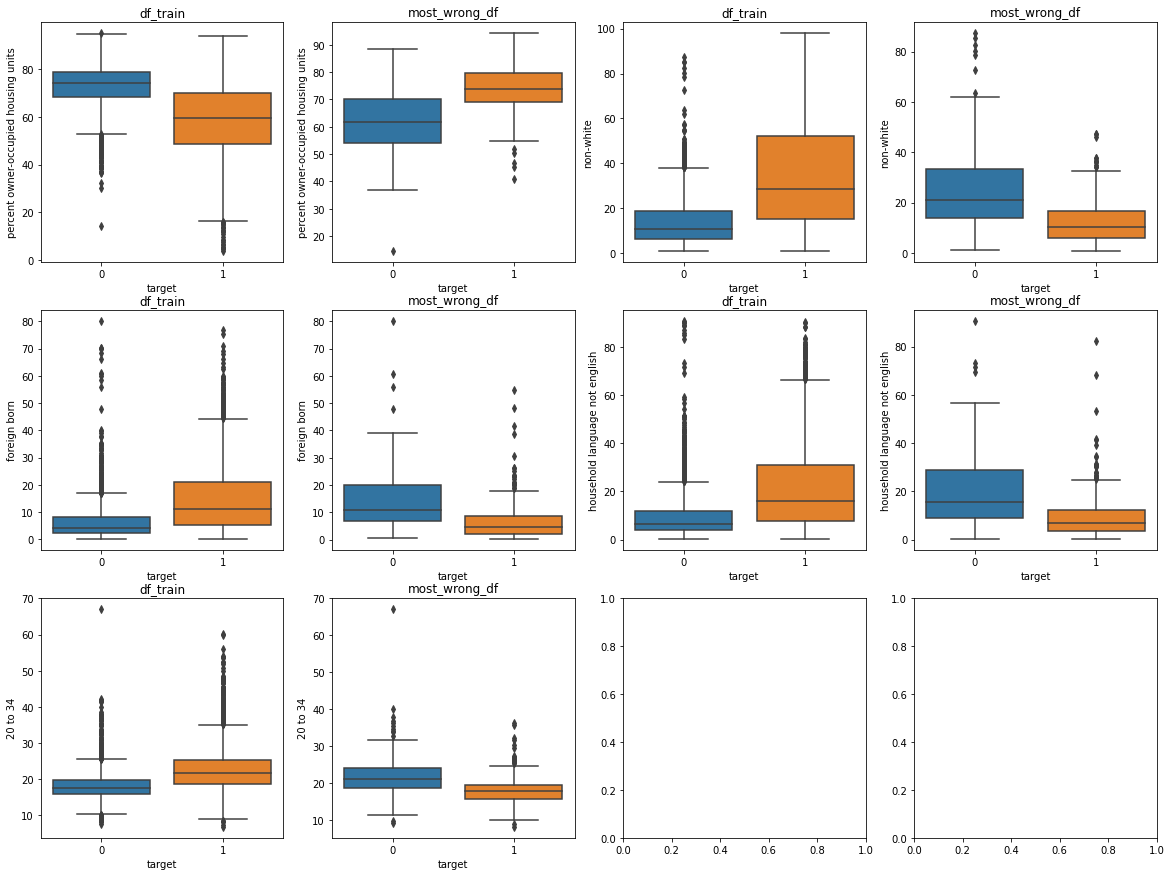

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
sns.boxplot(x="target", y="percent owner-occupied housing units", data=df_train, ax=ax[0, 0])
ax[0, 0].set_title("df_train")
sns.boxplot(x="target", y="percent owner-occupied housing units", data=most_wrong_df, ax=ax[0, 1])
ax[0, 1].set_title("most_wrong_df")

sns.boxplot(x="target", y="non-white", data=df_train, ax=ax[0, 2])
ax[0, 2].set_title("df_train")
sns.boxplot(x="target", y="non-white", data=most_wrong_df, ax=ax[0, 3])
ax[0, 3].set_title("most_wrong_df")

sns.boxplot(x="target", y="foreign born", data=df_train, ax=ax[1, 0])
ax[1, 0].set_title("df_train")
sns.boxplot(x="target", y="foreign born", data=most_wrong_df, ax=ax[1, 1])
ax[1, 1].set_title("most_wrong_df")

sns.boxplot(x="target", y="household language not english", data=df_train, ax=ax[1, 2])
ax[1, 2].set_title("df_train")
sns.boxplot(x="target", y="household language not english", data=most_wrong_df, ax=ax[1, 3])
ax[1, 3].set_title("most_wrong_df")

sns.boxplot(x="target", y="20 to 34", data=df_train, ax=ax[2, 0])
ax[2, 0].set_title("df_train")
sns.boxplot(x="target", y="20 to 34", data=most_wrong_df, ax=ax[2, 1])
ax[2, 1].set_title("most_wrong_df");

In the plots of these five features it's clearly visible that the mean and the distribution for each target class changes between the whole training set and the most_wrong_df. This seems to confuse the models.

In [ ]:
# Check for prediction with highest residual -> quasi most wrong single prediction
residuals.loc[residuals == residuals.min()]

6297   -5.06766
Name: target, dtype: float64

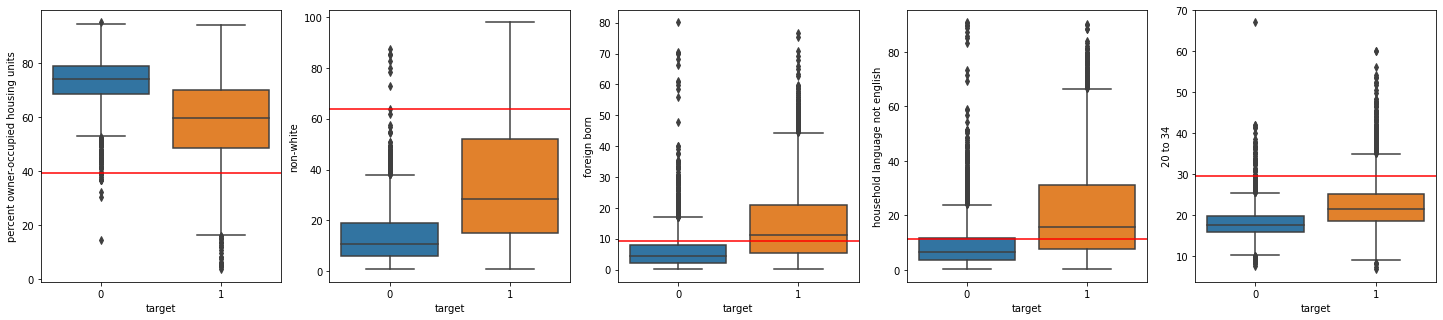

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
sns.boxplot(x="target", y="percent owner-occupied housing units", data=df_train, ax=ax[0])
ax[0].axhline(df_train.loc[6297, "percent owner-occupied housing units"], color="r")

sns.boxplot(x="target", y="non-white", data=df_train, ax=ax[1])
ax[1].axhline(df_train.loc[6297, "non-white"], color="r")

sns.boxplot(x="target", y="foreign born", data=df_train, ax=ax[2])
ax[2].axhline(df_train.loc[6297, "foreign born"], color="r")

sns.boxplot(x="target", y="household language not english", data=df_train, ax=ax[3])
ax[3].axhline(df_train.loc[6297, "household language not english"], color="r")

sns.boxplot(x="target", y="20 to 34", data=df_train, ax=ax[4])
ax[4].axhline(df_train.loc[6297, "20 to 34"], color="r")

# Feature Engineering

## Discretization

In [ ]:
def disc_strategy(X, y, list_of_models, min=5, max=30, step=2):
  """ Calculates log loss of two models. Both single variable model, one without 
  discretization and one with discretization (only of tyipe ordinal). Then, it compares their loss scores
  against each other and calculates a p value for statistical significance in
  the difference of the cross validated mean."""

  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Create DataFrame to save all accuracies of the different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=23)

  list_of_results, p_values = [], []
  # Create temporary DataFrame to save the model specific accuracies
  df_accuracies = pd.DataFrame()
  df_baselines = pd.DataFrame()
  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Standardize Data if model = LogReg, KNN or SVC
    pipe = Pipeline(steps=[("std", StandardScaler()), ("model", model)])    
    results = {}
    # Cross validation loop
    for n_feat, feature in enumerate(X_new.drop("year", axis=1).columns):
      print(feature)
      # Dictionary to save all results and to convert it to a DataFrame later on
      results[feature] = {}
      # Variable to check for lowest mean and save the cross validated loss score
      best_result = -np.inf   
      # Feature column
      #results["feature"] = feature
      # Add baseline to results DataFrame
      #results["baseline"] = np.mean(baseline)
      #df_baselines.loc[n_feat, f"{model}_baseline"] = np.mean(baseline)
      
      # All variations of discretization from 2-10 bins, with ordinal ane onehot encoding and uniform/quantile/kmeans strategy
      for n_bins in range(min, max+1, step):
        for strategy in ["uniform", "quantile", "kmeans"]:
          # Discretizing
          discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy=strategy)
          new_feature = discretizer.fit_transform(X_new[feature].to_frame())
          #new_feature_val = discretizer.transform(X_val[feature].to_frame())
          # Add new features to respective DataFrames
          X_disc = pd.concat([X_new, pd.Series(new_feature.ravel())], axis=1)
          #X_val_new = pd.concat([X_val, pd.Series(new_feature_val.ravel())], axis=1)
          if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
            # Pipeline with standardizing and prediction
            scores = cross_val_score(pipe, X_disc, y_new, cv=kfold, scoring="accuracy", n_jobs=-1)
          else:
            # Only prediction
            scores = cross_val_score(model, X_disc, y_new, cv=kfold, scoring="accuracy", n_jobs=-1)
          df_accuracies[f"{feature}_{n_bins}_{strategy}"] = scores
  return df_accuracies

In [ ]:
df_disc_strategy = disc_strategy(X, y, [LogisticRegression()])

LogisticRegression()
district
percent households receiving food stamps
state
percent uninsured
household language not english
non-white
black/afroamerican
percent female
under 20
20 to 34
35 to 49
50 to 64
65 and over
median age
monthly housing costs - $499 or lower
monthly housing costs - $500 - 999
monthly housing costs - $1000 1999
monthly housing costs - $2000 or higher
monthly housing costs - median
percent owner-occupied housing units
average family size
foreign born
percent of tot. population in poverty
management, business, science, and arts occupations
service occupations
sales and office occupations
blue collar occupations
earnings $1 - $24'999
earnings $25'000 - 49'999
earnings $50'000 - 74'999
earnings $75'000 or more
median earnings
less than highschool
highschool
college or associate
bachelor or higher


In [ ]:
df_disc_strategy.to_csv("drive/MyDrive/US Elections/Notebook Data/df_disc_strategy.csv", index=False)

In [ ]:
df_disc_strategy = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/df_disc_strategy.csv")

In [ ]:
best_strategies = []
for col in range(36):
  indices = []
  indices.extend(df_disc_strategy.iloc[:, (col*39):(col+1)*39].columns.tolist())
  best_strategies.append(df_disc_strategy.loc[:, indices].mean().idxmax())

In [ ]:
best_strategies = [strat.split("_")[-2:] for strat in best_strategies]

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/best_strategies.pickle", "wb") as best_strategies_:
  pickle.dump(best_strategies, best_strategies_)

In [ ]:
disc_strategies = list(zip(X.drop("year", axis=1).columns, best_strategies))
disc_strategies

[('district', ['5', 'quantile']),
 ('percent households receiving food stamps', ['11', 'quantile']),
 ('state', ['23', 'quantile']),
 ('percent uninsured', ['13', 'quantile']),
 ('household language not english', ['5', 'quantile']),
 ('non-white', ['19', 'quantile']),
 ('black/afroamerican', ['21', 'quantile']),
 ('percent female', ['9', 'kmeans']),
 ('under 20', ['13', 'quantile']),
 ('20 to 34', ['27', 'kmeans']),
 ('35 to 49', ['29', 'kmeans']),
 ('50 to 64', ['7', 'quantile']),
 ('65 and over', ['7', 'quantile']),
 ('median age', ['13', 'uniform']),
 ('monthly housing costs - $499 or lower', ['25', 'uniform']),
 ('monthly housing costs - $500 - 999', ['15', 'kmeans']),
 ('monthly housing costs - $1000 1999', ['23', 'uniform']),
 ('monthly housing costs - $2000 or higher', ['15', 'quantile']),
 ('monthly housing costs - median', ['15', 'kmeans']),
 ('percent owner-occupied housing units', ['17', 'quantile']),
 ('average family size', ['13', 'quantile']),
 ('foreign born', ['19', 'un

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/disc_strategies.pickle', 'wb') as disc_strategies_:
    pickle.dump(disc_strategies, disc_strategies_)

## Interaction Effects

In [ ]:
def find_interactions(X, y, n_rounds, p_value=0.1):
  """
  
  """
  X_new = X.copy().reset_index(drop=True)
  y_new = y.copy().reset_index(drop=True)
  # Create interaction DataFrame
  poly = PolynomialFeatures(interaction_only=True, include_bias=False)
  X_interaction = poly.fit_transform(X_new)
  X_interaction = pd.DataFrame(X_interaction, columns=poly.get_feature_names_out())
  # Instantiate LassoRegression
  log_reg = LogisticRegression(C=2, penalty="l1", solver="liblinear")
  # Create bootstrap resampling method
  list_cols = [] # list to save all the columns which are non null
  for i in range(n_rounds):
    # Take a fraction of the sample with bootstrapping
    X_boot = X_interaction.sample(frac=0.3, replace=True)
    # Scale variables
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_boot)
    X_scaled = pd.DataFrame(X_scaled, columns=scaler.get_feature_names_out())
    # Save indices of the chosen instances for y
    indices = X_scaled.index
    log_reg.fit(X_scaled, y_new.iloc[indices])
    # Check for all non-null values and save columns with non-null values to list
    important_cols = log_reg.coef_[0] != 0
    cols = X_interaction.columns[important_cols].tolist()
    list_cols.extend(cols)
  # Flatten the list
  #list_cols = [i for liste in list_cols for i in liste]
  # Value count of main and interaction effects
  cols = np.unique(list_cols, return_counts=True)[0]
  # 1 - (no. of times non-null / n_round) = p-value
  n_occur = 1 - (np.unique(list_cols, return_counts=True)[1] / n_rounds)
  final_list = sorted(list(zip(n_occur, cols)))

  # Calculate significant interactions
  significant_interactions = []
  for interaction in final_list:
    if interaction[0] < 0.1:
      significant_interactions.append(interaction[1])
    else:
      break
  
  return final_list, significant_interactions

In [ ]:
%%time
list_cols, significant_interactions = find_interactions(X, y, n_rounds=1000, p_value=0.1)

CPU times: user 3h 14min 34s, sys: 9.57 s, total: 3h 14min 44s
Wall time: 3h 13min 54s


In [ ]:
significant_interactions

['year', 'district state']

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/interaction_list.pickle', 'wb') as interaction_list:
    pickle.dump(list_cols, interaction_list)

In [ ]:
# Interactions to consider
list_cols[:3]

[(0.050000000000000044, 'year'),
 (0.07499999999999996, 'district state'),
 (0.125, 'district percent uninsured')]

In [ ]:
def create_interactions(X):
  X_new = pd.DataFrame()
  X_new["district*state"] = X["district"] * X["state"]
  X_new["district*percent uninsured"] = X["district"] * X["percent uninsured"]
  return X_new

In [ ]:
X_interactions = create_interactions(X)
X_interactions.head()

,district*state,district*percent uninsured
606,7,16.1
1228,5292,8687.7
5259,6202,3145.3
4134,932,1281.5
4734,45,25.5


## Feature Generation with Decision Trees

In [ ]:
def cv_feature_generator(X, y, list_of_models=list, min=2, max=4):
  """ For different models this function creates gradient boosted features with GradientBoostingFeatureGenerator.
  The results for different tree depths are then cross validated. The DataFrame with all the cross validation 
  results as well as the strategy with the best median accuracy will be returned.
  """
  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Creating DataFrame for saving the accuracies of different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)

  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Create temporary DataFrame to save the model specific accuracies
    df_accuracies = pd.DataFrame()
    df_baselines = pd.DataFrame()

    # Cross validation loop
    for num, (train, val) in enumerate(kfold.split(X_new, y_new)):
      # Create training and validation folds
      X_train, X_val = X_new.iloc[train], X_new.iloc[val]
      y_train, y_val = y_new[train], y_new[val]
      # Loop over strategies for tree depth
      for depth in range(min, max+1):
        # Create instance of feature generator, fit and transform the train and validation set
        gbfg = GradientBoostingFeatureGenerator(n_estimators=1, max_depth=depth)
        X_train_new = np.asarray(gbfg.fit_transform(X_train, y_train))
        X_val_new = np.asarray(gbfg.transform(X_val))

        if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
          sc = StandardScaler()
          X_train_new = sc.fit_transform(X_train_new)
          X_val_new = sc.transform(X_val_new)
          X_train_new, X_val_new = pd.DataFrame(X_train_new, columns=sc.get_feature_names_out()), pd.DataFrame(X_val_new, columns=sc.get_feature_names_out())

        model.fit(X_train_new, y_train)
        accuracy = model.score(X_val_new, y_val)
        df_accuracies.loc[num, str(model)[:-2]+"_depth_"+str(depth)] = accuracy
    # Concatenate DataFrame of new model to the total DataFrame
    df_total = pd.concat([df_total, df_accuracies], axis=1)

  # strategy wählen mit höchstem median value
  #strategy = df_accuracies.median().idxmax() # gibt zb "depth_2"
  n_depths = (max+1)-min
  
  # List to save the depth-strategies for different models
  strategies = []
  for col_idx in range(n_depths, df_total.shape[1]+1, n_depths):
    strategy = df_total.iloc[:, col_idx-n_depths:col_idx].median().idxmax()
    strategies.append(strategy)

  return df_total, strategies

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), 
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier()]

In [ ]:
%%time
fg_df, fg_strategies = cv_feature_generator(X, y, list_of_models, 
                                            min=2, max=5)

In [ ]:
fg_df.mean()

LogisticRegression_depth_2                                           0.835129
LogisticRegression_depth_3                                           0.841127
LogisticRegression_depth_4                                           0.840128
LogisticRegression_depth_5                                           0.836893
KNeighborsClassifier_depth_2                                         0.833774
KNeighborsClassifier_depth_3                                         0.835304
KNeighborsClassifier_depth_4                                         0.827594
KNeighborsClassifier_depth_5                                         0.821239
SVC_depth_2                                                          0.864019
SVC_depth_3                                                          0.864488
SVC_depth_4                                                          0.852309
SVC_depth_5                                                          0.839481
RandomForestClassifier_depth_2                                  

In [ ]:
fg_strategies

['LogisticRegression_depth_3',
 'KNeighborsClassifier_depth_3',
 'SVC_depth_3',
 'RandomForestClassifier_depth_4',
 'XGBClassifier_depth_2',
 'LGBMClassifier_depth_2',
 'HistGradientBoostingClassifier_depth_2',
 '<catboost.core.CatBoostClassifier object at 0x7faf1e142c5_depth_2']

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/feature_generation.pickle', 'wb') as feature_generation:
    pickle.dump(fg_df, feature_generation)

## Drop correlated Features

In [ ]:
def get_drop_correlated_strategy(X, y, list_of_models, min=0.75, max=0.9, steps=16):
  """Cross validated feature dropping with different correlation thresholds. DataFrame with cross validation
  accuracies and strategies for each model are returned. 
  """
  # Creating copies of the original DataFrame
  X_new = X.reset_index(drop=True) # reset so that cross validation works afterwards
  y_new = y.reset_index(drop=True)
  # Create DataFrame to save all accuracies of the different models
  df_total = pd.DataFrame()
  # Cross validation strategy
  kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=23)

  # Loop over all the models
  for model in list_of_models:
    print(model)
    # Create temporary DataFrame to save the model specific accuracies
    df_accuracies = pd.DataFrame()
    # Cross validation loop
    for num, (train, val) in enumerate(kfold.split(X_new, y_new)):
      # Create training and validation folds
      X_train, X_val = X_new.iloc[train], X_new.iloc[val]
      y_train, y_val = y_new[train], y_new[val]

      # Create correlation matrix
      corr_matrix = pd.concat([X_train, y_train], axis=1).corr()
      # Create dictionaries to save results and dataframes
      results, dataframes = {}, {}
  
      # Loop through all relevant correlation thresholds
      for threshold in np.linspace(min, max, steps):
        # Create list for drop out features
        to_drop = []
        # Loop through all the columns (except they are already dropped out)
        for feature in corr_matrix.columns:
          # Check if feature is in to drop -> doesn't have to be checked for correlation anymore
          if feature in to_drop:
            continue
          # Check for correlations of > threshold
          high_correlations = corr_matrix[abs(corr_matrix[feature]) > threshold].index.tolist()
          # Subtract 1 (=feature) -> when subtracted and no correlations list will be = 0 -> if statement not executed
          if len(high_correlations)-1:
            corr_matrix_temp = corr_matrix[[*high_correlations, "target"]].corr()      
            # Get maximum correlation with target and remove it from the list of correlated features
            best_index = corr_matrix_temp.drop("target")["target"].idxmin() # CHANGE TO IDXMIN -> SEE WHAT HAPPENS
            high_correlations.remove(best_index)
            to_drop.extend(high_correlations)
        to_drop = set(to_drop)
        X_train_dropped = X_train.drop(to_drop, axis=1)
        X_val_dropped = X_val.drop(to_drop, axis=1)

        if type(model) in [type(LogisticRegression()), type(KNeighborsClassifier()), type(SVC())]:
              sc = StandardScaler()
              X_train_dropped = sc.fit_transform(X_train_dropped)
              X_val_dropped = sc.transform(X_val_dropped)
              X_train_dropped, X_val_dropped = pd.DataFrame(X_train_dropped, columns=sc.get_feature_names_out()), pd.DataFrame(X_val_dropped, columns=sc.get_feature_names_out())
        
        # Calculate score for respective fold
        model.fit(X_train_dropped, y_train)
        accuracy = model.score(X_val_dropped, y_val)
        df_accuracies.loc[num, str(model)[:-2]+"_"+str(threshold)] = accuracy
      
    # Concatenate DataFrame of new model to the total DataFrame
    df_total = pd.concat([df_total, df_accuracies], axis=1) 
    
  # Find best strategy for each model
  strategies = {}
  for num, col_idx in enumerate(range(steps, df_total.shape[1]+1, steps)):
    strategy = df_total.iloc[:, col_idx-steps:col_idx].mean().idxmax()
    strategies[str(list_of_models[num])] = float(strategy.split("_")[1])
  #df_total = df_total.append(df_total.median(), ignore_index=True)
  #df_total = df_total.rename(index={kfold.get_n_splits():"median"})
  
  return df_total, strategies

In [ ]:
%%time
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier(), 
                  XGBClassifier(), HistGradientBoostingClassifier(), LGBMClassifier(), 
                  CatBoostClassifier()]
corr_df, corr_strategies = get_drop_correlated_strategy(X, y, list_of_models, min=0.75, max=0.9, steps=16)

In [ ]:
corr_df.to_csv("drive/MyDrive/US Elections/Notebook Data/corr_df.csv", index=False)

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "wb") as corr_strategies_:
  pickle.dump(corr_strategies, corr_strategies_)

In [ ]:
pd.set_option("display.max_rows", None)
corr_df.mean()

In [ ]:
# For different algorithms
corr_strategies

{'<catboost.core.CatBoostClassifier object at 0x7f76b95ec9d0>': 0.87,
 'HistGradientBoostingClassifier()': 0.8300000000000001,
 'KNeighborsClassifier()': 0.87,
 'LGBMClassifier()': 0.85,
 'LogisticRegression()': 0.87,
 'RandomForestClassifier()': 0.81,
 'SVC()': 0.8200000000000001,
 'XGBClassifier()': 0.88}

In [ ]:
def drop_correlated_features(X, y, corr_strategies):
  corr_matrix = pd.concat([X, y], axis=1).corr()
  corr_dfs = {}
  for model, threshold in corr_strategies.items():
    to_drop = []
    for feature in [col for col in corr_matrix.columns if col not in to_drop]:
      # Check for correlations of > threshold
      high_correlations = corr_matrix[abs(corr_matrix[feature]) > threshold].index.tolist()
      # Subtract 1 (=feature) -> when subtracted and no correlations list will be = 0 -> if statement not executed
      if len(high_correlations)-1:
        corr_matrix_temp = corr_matrix[[*high_correlations, "target"]].corr()      
        # Get maximum correlation with target and remove it from the list of correlated features
        best_index = corr_matrix_temp.drop("target")["target"].idxmax() # CHANGE TO IDXMIN -> SEE WHAT HAPPENS
        high_correlations.remove(best_index)
        to_drop.extend(high_correlations)
    to_drop = set(to_drop)
    X_dropped = X.drop(to_drop, axis=1)
    corr_dfs[str(model)] = X_dropped
  return corr_dfs

In [ ]:
# Drop correlated features
corr_dfs = drop_correlated_features(X, y, corr_strategies)

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_dfs.pickle", "wb") as corr_dfs_:
  pickle.dump(corr_dfs, corr_dfs_)

## Evaluation Pipeline

Evaluate best scaling and transformation strategy.

In [ ]:
def evaluate_model(X, y, model):
  # Cross validation
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
	# Model Evaluation
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

In [ ]:
def get_pipelines(X):
  pipelines = []
  model_ = model
  orig_cols = X.columns.tolist()
  #all_cols = X_new.columns.tolist()
  # Normal
  p_normal = Pipeline(steps=[("model", model)])
  pipelines.append(("p_normal", p_normal))
  # MinMax
  p_minmax = Pipeline(steps=[("minmax", MinMaxScaler()), ("model", model)])
  pipelines.append(("minmax", p_minmax))
  # Normalized
  p_normalized = Pipeline(steps=[("norm", Normalizer()), ("model", model)])
  pipelines.append(("norm", p_normalized))
  # Robust
  p_robust = Pipeline(steps=[("robust", RobustScaler()), ("model", model)])
  pipelines.append(("robust", p_robust))
  # Standardized
  p_stand = Pipeline(steps=[("stand", StandardScaler()), ("model", model)])
  pipelines.append(("stand", p_stand))

  transformer = Pipeline([("trans", PowerTransformer(standardize=False))])
  # Transform_MinMax
  minmax = ColumnTransformer([("trans", transformer, orig_cols), ("minmax", MinMaxScaler(), orig_cols)])
  t_minmax = Pipeline(steps=[("prep", minmax), ("model", model)])
  pipelines.append(("t_minmax", t_minmax))
  # Transform_Normalized
  normalized = ColumnTransformer([("trans", transformer, orig_cols), ("norm", Normalizer(), orig_cols)])
  t_normalized = Pipeline(steps=[("prep", normalized), ("model", model)])
  pipelines.append(("t_norm", t_normalized))
  # Transform_Robust
  robust = ColumnTransformer([("trans", transformer, orig_cols), ("robust", RobustScaler(), orig_cols)])
  t_robust = Pipeline(steps=[("prep", robust), ("model", model)])
  pipelines.append(("t_robust", t_robust))
  # Transform_Standardized
  stand = ColumnTransformer([("trans", transformer, orig_cols), ("stand", StandardScaler(), orig_cols)])
  t_stand = Pipeline(steps=[("prep", stand), ("model", model)])
  pipelines.append(("t_stand", t_stand))

  return pipelines

In [ ]:
models = [LogisticRegression(), XGBClassifier(), LGBMClassifier()]
results = []

for model in models:
  print(model)
  pipelines = get_pipelines(X)
  for name, pipe in pipelines:
    scores = evaluate_model(X, y, pipe)
    results.append((model, name, round(np.mean(scores)*100, 4), round(np.std(scores), 4)))

LogisticRegression()
XGBClassifier()
LGBMClassifier()


In [ ]:
results

[(LogisticRegression(), 'p_normal', 81.2004, 0.0177),
 (LogisticRegression(), 'minmax', 83.371, 0.0176),
 (LogisticRegression(), 'norm', 55.8343, 0.0069),
 (LogisticRegression(), 'robust', 83.5655, 0.0152),
 (LogisticRegression(), 'stand', 83.6539, 0.0159),
 (LogisticRegression(), 't_minmax', 77.1224, 0.0169),
 (LogisticRegression(), 't_norm', 77.1581, 0.0165),
 (LogisticRegression(), 't_robust', 77.2637, 0.0166),
 (LogisticRegression(), 't_stand', 77.0344, 0.0172),
 (XGBClassifier(), 'p_normal', 85.3135, 0.0081),
 (XGBClassifier(), 'minmax', 85.3135, 0.0081),
 (XGBClassifier(), 'norm', 84.4305, 0.0154),
 (XGBClassifier(), 'robust', 85.3135, 0.0081),
 (XGBClassifier(), 'stand', 85.3135, 0.0081),
 (XGBClassifier(), 't_minmax', 85.3135, 0.0081),
 (XGBClassifier(), 't_norm', 85.5958, 0.0135),
 (XGBClassifier(), 't_robust', 85.3135, 0.0081),
 (XGBClassifier(), 't_stand', 85.3135, 0.0081),
 (LGBMClassifier(), 'p_normal', 86.9549, 0.0082),
 (LGBMClassifier(), 'minmax', 86.7435, 0.0061),
 (LG

## Feature Selection

### Including random variable

In [ ]:
def feature_selection_dt(X, y):
  random_feature = pd.Series(np.random.randint(0, 100, 5665), name="random_feature")
  X_new = pd.concat([X.reset_index(drop=True), random_feature], axis=1)
  y_new = y.reset_index(drop=True)
  print(X_new.shape)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
  bad_features = []
  for num, (train, val) in enumerate(cv.split(X_new, y_new)):
    if num % 5 == 0:
      print(num)
    X_train, X_val = X_new.iloc[train], X_new.iloc[val]
    y_train, y_val = y.iloc[train], y.iloc[val]

    tree_clf = RandomForestClassifier()
    tree_clf.fit(X_train, y_train)
    features = X_new.columns[tree_clf.feature_importances_ < tree_clf.feature_importances_[-1]]
    bad_features.extend(features)
  return bad_features

In [ ]:
bad_features = feature_selection_dt(X, y)

(5665, 38)
0


In [ ]:
# In every resample year has a worse feature importance than the added random variable
# ---> drop year variable
np.unique(bad_features, return_counts=True)

(array(["earnings $75'000 or more", 'year'], dtype='<U24'), array([ 1, 30]))

### Minimum Redundancy Maximum Relevance

In [ ]:
!pip install mrmr_selection
import mrmr

In [ ]:
# select top 10 features using mRMR
from mrmr import mrmr_classif

In [ ]:
selected_features = mrmr_classif(X=X_train_lr, y=y.reset_index(drop=True), K=30)

100%|██████████| 30/30 [00:06<00:00,  4.41it/s]


In [ ]:
selected_features

['percent owner-occupied housing units',
 'monthly housing costs - median_disc',
 'non-white',
 'fg_4',
 'percent owner-occupied housing units_disc',
 'non-white_disc',
 'fg_0',
 'management, business, science, and arts occupations*blue collar occupations',
 '20 to 34_disc',
 'household language not english',
 'non-white*black/afroamerican',
 'household language not english_disc',
 '20 to 34',
 'foreign born_disc',
 'black/afroamerican',
 'foreign born',
 'service occupations_disc',
 'percent female',
 'percent households receiving food stamps',
 'district*black/afroamerican',
 'monthly housing costs - $499 or lower*monthly housing costs - $1000 1999',
 'black/afroamerican_disc',
 'service occupations',
 'blue collar occupations_disc',
 'percent uninsured*black/afroamerican',
 'percent female_disc',
 'median age',
 'fg_7',
 'blue collar occupations',
 'percent of tot. population in poverty']

In [ ]:
scores = cross_val_score(HistGradientBoostingClassifier(), X[selected_features], y, 
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=35),
                         scoring="accuracy", n_jobs=-1, verbose=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.9s finished


In [ ]:
np.mean(scores), np.std(scores), scores

(0.827535870606149,
 0.014161678377086465,
 array([0.81128748, 0.84303351, 0.82010582, 0.85890653, 0.81481481,
        0.83568905, 0.81448763, 0.8180212 , 0.79681979, 0.84275618,
        0.83421517, 0.84656085, 0.8377425 , 0.83597884, 0.81834215,
        0.81272085, 0.82508834, 0.81448763, 0.82332155, 0.83745583,
        0.81128748, 0.8324515 , 0.83950617, 0.80070547, 0.83597884,
        0.83215548, 0.83392226, 0.83215548, 0.84452297, 0.82155477]))

In [ ]:
np.arange(5, 31, 5)

In [ ]:
X_new.shape

(5665, 44)

In [ ]:
from mrmr import mrmr_classif

def feature_selection_mrmr(X, y):
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=39)
  for model in zip(list_of_models, :
    print(model)
    for num, (train, val) in enumerate(cv.split(X, y)):
      print(num)
      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y.iloc[train], y.iloc[val]
      for i in range(21, 38, 2):
        selected_features = mrmr_classif(X=X_train, y=y_train, K=i)
        model.fit(X_train[selected_features], y_train)
        score = model.score(X_val[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
for i 
mrmr_scores = feature_selection_mrmr(X, y)

In [ ]:
mrmr_scores.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores.csv", index=False)

# Preparing Training Data

## Different Datasets

X normal = **X** <br>
X normals without correlated = **dict_of_Xs** <br>
X_disc = **X_new** <br>
X_discs without correlated = **dict_of_X_discs**


In [ ]:
y_new = y.reset_index(drop=True)

In [ ]:
# Discretization

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/disc_strategies.pickle', 'rb') as disc_strategies_:
    disc_strategies = pickle.load(disc_strategies_)
with open('drive/MyDrive/US Elections/Notebook Data/best_strategies.pickle', 'rb') as best_strategies_:
    best_strategies = pickle.load(best_strategies_)

In [ ]:
def discretizer(X):
  """Creates discretized versions of the original columns for all columns regardless of its relation to the target."""
  X_new = X.reset_index(drop=True).copy()
  X_disc = pd.DataFrame()
  for col, strat in zip(X_new.drop("year", axis=1).columns, best_strategies):
    kbins = KBinsDiscretizer(n_bins=int(strat[0]), encode="ordinal", strategy=strat[1])
    disc_feature = kbins.fit_transform(X[col].to_frame()).ravel()
    X_disc = pd.concat([X_disc, pd.Series(disc_feature, name=f"{col}_disc")], axis=1)
  return X_disc

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
X_disc = discretizer(X)

In [ ]:
def drop_disc_normal_column(X, X_disc, y):
  """Decides which discretized columns actually have a stronger correlation with the target than the original columns.
  Those columns are kept as part of the DataFrame X_disc."""
  disc_cols_to_keep = [] # discretized cols to keep
  normal_cols_to_drop = []
  X_new = X.reset_index(drop=True)
  y_new = y.reset_index(drop=True)
  for col in X_new.columns[:-1]: # year has no discretized column
    if col in ["district", "state"]:
      continue
    corr_normal = abs(X_new[col].corr(y_new))
    corr_disc = abs(X_disc[f"{col}_disc"].corr(y_new))
    if corr_disc >= corr_normal:
      disc_cols_to_keep.append(f"{col}_disc")
      normal_cols_to_drop.append(col)
  return disc_cols_to_keep, normal_cols_to_drop

In [ ]:
disc_cols_to_keep, normal_cols_to_drop = drop_disc_normal_column(X, X_disc, y)

In [ ]:
# Keep the relevant columns of discretized DataFrame
X_disc = X_disc[disc_cols_to_keep]
X_new = pd.concat([X.drop(normal_cols_to_drop, axis=1).reset_index(drop=True), X_disc], axis=1)

In [ ]:
scores = cross_val_score(LGBMClassifier(),
                         X_new,
                         y.reset_index(drop=True),
                         cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3),
                         scoring="accuracy",
                         n_jobs=-1)

In [ ]:
np.mean(scores), np.std(scores), scores

(0.8678426533550208,
 0.014932388616567347,
 array([0.86772487, 0.85714286, 0.88007055, 0.86419753, 0.86948854,
        0.87279152, 0.86925795, 0.87279152, 0.85689046, 0.8745583 ,
        0.88007055, 0.87301587, 0.89594356, 0.85890653, 0.85714286,
        0.88869258, 0.87632509, 0.87809187, 0.8639576 , 0.83922261,
        0.86243386, 0.85361552, 0.85537919, 0.86948854, 0.88712522,
        0.8639576 , 0.82862191, 0.85865724, 0.85865724, 0.90106007]))

In [ ]:
# Interactions

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/interaction_list.pickle', 'rb') as interaction_list:
    list_cols = pickle.load(interaction_list)

In [ ]:
def create_interactions(X):
  X_new = pd.DataFrame()
  X_new["district*state"] = X["district"] * X["state"]
  X_new["district*percent uninsured"] = X["district"] * X["percent uninsured"]
  return X_new

In [ ]:
X_interactions = create_interactions(X)
X_interactions.head()

,district*state,district*percent uninsured
606,7,16.1
1228,5292,8687.7
5259,6202,3145.3
4134,932,1281.5
4734,45,25.5


In [ ]:
# Feature Generation

In [ ]:
with open('drive/MyDrive/US Elections/Notebook Data/feature_generation.pickle', 'rb') as feature_generation:
    fg_df = pickle.load(feature_generation)

In [ ]:
def feature_generation(X, y, fg_df):
  fg_strategy, fg_dataframes = {}, {}
  for num in range(8):
    strat = fg_df[fg_df.iloc[:, (num*4):(num+1)*4].columns].mean().idxmax().split("_")
    fg_strategy[f"{strat[0]}()"] = strat[-1]

  for num, (model, depth) in enumerate(fg_strategy.items()):
    gbfg = GradientBoostingFeatureGenerator(stack_to_X=False, n_estimators=1, max_depth=int(depth))
    X_new = gbfg.fit_transform(X, y)
    fg_dataframes[str(model)] = pd.DataFrame(X_new, columns=[f"fg_{i}" for i in range(X_new.shape[1])])
  return fg_dataframes

In [ ]:
# Dictionary with DataFrames for all different algorithms
fg_dfs = feature_generation(X, y, fg_df)

In [ ]:
# Drop correlated Features

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_dfs.pickle", "rb") as corr_dfs_:
  corr_dfs = pickle.load(corr_dfs_)

In [ ]:
# Rename CatBoost key in dictionaries
corr_dfs["CatBoostClassifier()"] = corr_dfs.pop(list(corr_dfs)[-1])
fg_dfs["CatBoostClassifier()"] = fg_dfs.pop(list(fg_dfs)[-1]) 
#cols_to_drop["CatBoostClassifier()"] = cols_to_drop.pop(list(cols_to_drop)[-1])

In [ ]:
def get_final_dfs(corr_dfs):
  final_dfs = []
  for model, df in corr_dfs.items():
    final_dfs.append(pd.concat([df.drop("year", axis=1).reset_index(drop=True), X_interactions.reset_index(drop=True), fg_dfs[str(model)]], axis=1))
  return final_dfs

In [ ]:
final_dfs = get_final_dfs(corr_dfs)

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/final_dfs.pickle", "wb") as final_dfs_:
    pickle.dump(final_dfs, final_dfs_)

In [ ]:
 with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "rb") as corr_strategies_:
  corr_strategies = pickle.load(corr_strategies_)

In [ ]:
from mrmr import mrmr_classif

def feature_selection_mrmr_final(list_of_final_dfs, y, list_of_models):
  y_new = y.reset_index(drop=True)
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=39)
  for model, X in zip(list_of_models, list_of_final_dfs):
    print(model)
    for num_split, (train, val) in enumerate(cv.split(X, y_new)):
      print(num_split)

      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y_new.iloc[train], y_new.iloc[val]

      transformer = PowerTransformer()
      X_train_new = transformer.fit_transform(X_train)
      X_train_new = pd.DataFrame(X_train_new, columns=transformer.get_feature_names_out())
      X_val_new = transformer.transform(X_val)
      X_val_new = pd.DataFrame(X_val_new, columns=transformer.get_feature_names_out())
      
      # Get no. of features for each DataFrame
      num_features = X_train.shape[1]

      for i in range(num_features-8, num_features+1, 2):
        selected_features = mrmr_classif(X=X_train_new, y=y_train.reset_index(drop=True), K=i)
        model.fit(X_train_new[selected_features], y_train)
        score = model.score(X_val_new[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
list_of_models = [LogisticRegression(), KNeighborsClassifier(), SVC(kernel="linear"), RandomForestClassifier(),
                  XGBClassifier(), LGBMClassifier(), HistGradientBoostingClassifier(), CatBoostClassifier(verbose=100)]

In [ ]:
mrmr_scores_final = feature_selection_mrmr_final(final_dfs, y_new, list_of_models)

In [ ]:
mrmr_scores_final.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_final.csv", index=False)

In [ ]:
strategies = [[36, 41], [28, 34], [30, 35], [27, 32], [31, 36], [29, 31], [26, 31], [33, 38]]

In [ ]:
def feature_selection_mrmr_final_2(list_of_final_dfs, y, list_of_models, strategies):
  y_new = y.reset_index(drop=True)
  scores = pd.DataFrame()
  cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=39)
  for model, X, strat in zip(list_of_models, list_of_final_dfs, strategies):
    print(model)
    for num_split, (train, val) in enumerate(cv.split(X, y_new)):
      print(num_split)

      X_train, X_val = X.iloc[train], X.iloc[val]
      y_train, y_val = y_new.iloc[train], y_new.iloc[val]

      transformer = PowerTransformer()
      X_train_new = transformer.fit_transform(X_train)
      X_train_new = pd.DataFrame(X_train_new, columns=transformer.get_feature_names_out())
      X_val_new = transformer.transform(X_val)
      X_val_new = pd.DataFrame(X_val_new, columns=transformer.get_feature_names_out())
      
      # Get no. of features for each DataFrame
      num_features = X_train.shape[1]

      for i in range(strat[0], strat[1]):
        selected_features = mrmr_classif(X=X_train_new, y=y_train.reset_index(drop=True), K=i)
        model.fit(X_train_new[selected_features], y_train)
        score = model.score(X_val_new[selected_features], y_val)
        scores.loc[num, f"{model}_{i}_features"] = score
  return scores

In [ ]:
mrmr_scores_2 = feature_selection_mrmr_final_2(final_dfs, y_new, list_of_models, strategies)

In [ ]:
mrmr_scores_2.mean()

LogisticRegression()_36_features                                           0.862191
LogisticRegression()_37_features                                           0.867491
LogisticRegression()_38_features                                           0.869258
LogisticRegression()_39_features                                           0.865724
LogisticRegression()_40_features                                           0.863958
KNeighborsClassifier()_28_features                                         0.855124
KNeighborsClassifier()_29_features                                         0.856890
KNeighborsClassifier()_30_features                                         0.874558
KNeighborsClassifier()_31_features                                         0.869258
KNeighborsClassifier()_32_features                                         0.869258
KNeighborsClassifier()_33_features                                         0.867491
SVC(kernel='linear')_30_features                                           0

In [ ]:
mrmr_scores_2.to_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_2.csv", index=False)

In [ ]:
mrmr_scores_final = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_final.csv")
mrmr_scores_2 = pd.read_csv("drive/MyDrive/US Elections/Notebook Data/mrmr_scores_2.csv")

In [ ]:
feature_sel_strategies = [38, 30, 32, 27, 33, 30, 28, 33]

## Hyperparamter Tuning

In [ ]:
def get_scores(model, X, y, feature_sel_strategy):
  selected_features = mrmr_classif(X=X, y=y, K=feature_sel_strategy)
  pipe = Pipeline(steps=[("transformer", PowerTransformer()), ("model", model)])
  scores = cross_val_score(pipe,
                           X[selected_features],
                           y,
                           scoring="accuracy",
                           cv=StratifiedKFold(n_splits=10),
                           n_jobs=1,
                           verbose=10)
  return (np.mean(scores), np.std(scores), scores)

In [ ]:
# Logistic Regression
param_dist = {
    "model__penalty": ["l2", None],
    "model__C": [1, 3, 4, 5, 10],
    "model__solver": ["lbfgs"],
    "model__max_iter": [100, 200, 500, 1000],

}

selected_features = mrmr_classif(X=final_dfs[0], y=y_new, K=feature_sel_strategies[0])

pipe_lr = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", LogisticRegression())])

rand_clf = RandomizedSearchCV(pipe_lr,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[0][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model', LogisticRegression(C=0.5, max_iter=300))]),
 0.8457083029521193)

In [ ]:
results_lr = get_scores(LogisticRegression(C=0.5, max_iter=500), final_dfs[0], y_new, feature_sel_strategies[0])

100%|██████████| 38/38 [00:02<00:00, 18.24it/s]


In [ ]:
results_lr

(0.8450068864085354,
 0.021738820637161167,
 array([0.86772487, 0.81657848, 0.89065256, 0.8377425 , 0.84832451,
        0.83215548, 0.84452297, 0.82508834, 0.82508834, 0.86219081]))

In [ ]:
# KNeighborsClassifier
param_dist = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 13, 15],
    "model__weights": ["uniform", "distance"]
}

selected_features = mrmr_classif(X=final_dfs[1], y=y_new, K=feature_sel_strategies[1])

pipe_knn = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", KNeighborsClassifier())])

rand_clf = RandomizedSearchCV(pipe_knn,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)
rand_clf.fit(final_dfs[1][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  KNeighborsClassifier(n_neighbors=11, weights='distance'))]),
 0.8382949751029845)

In [ ]:
results_knn = get_scores(KNeighborsClassifier(n_neighbors=11, weights='distance'), 
                         final_dfs[1], y_new, feature_sel_strategies[1])

100%|██████████| 30/30 [00:01<00:00, 15.33it/s]


In [ ]:
results_knn

(0.8382949751029845,
 0.013103891078187033,
 array([0.85714286, 0.84303351, 0.85185185, 0.85714286, 0.84126984,
        0.81978799, 0.82862191, 0.83215548, 0.82332155, 0.82862191]))

In [ ]:
# SVC
param_dist = {
    "model__kernel": ["linear", "rbf", "sigmoid"],
    "model__C": [0.3, 1, 3],
    "model__tol": [1e-3, 1e-4, 1e-5]
}

selected_features = mrmr_classif(X=final_dfs[2], y=y_new, K=feature_sel_strategies[2])

pipe_svc = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", SVC())])

rand_clf = RandomizedSearchCV(pipe_svc,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[2][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model', SVC(C=3, tol=0.0001))]), 0.8534799733268519)

In [ ]:
results_svc = get_scores(SVC(C=3, tol=0.0001), final_dfs[2], y_new, feature_sel_strategies[2])

100%|██████████| 32/32 [00:02<00:00, 14.66it/s]


In [ ]:
results_svc

(0.8534799733268519,
 0.0122265535074803,
 array([0.86772487, 0.84126984, 0.87477954, 0.86243386, 0.85714286,
        0.8409894 , 0.83922261, 0.84452297, 0.84452297, 0.86219081]))

In [ ]:
# RandomForestClassifier
param_dist = {
    "model__n_estimators": [100, 200, 500],
    "model__max_features": [0.4, 0.5, 0.6],
    #"model__max_depth": [8, 12, None],
    "model__max_samples": [0.5, 0.6, 0.75],
    #"model__min_samples_split": [2, 3, 4],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

selected_features = mrmr_classif(X=final_dfs[3], y=y_new, K=feature_sel_strategies[3])

pipe_rf = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", RandomForestClassifier())])

rand_clf = RandomizedSearchCV(pipe_rf,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[3][selected_features], y_new)

In [ ]:
results_rf = get_scores(RandomForestClassifier(max_features=0.5, min_samples_leaf=2, min_samples_split=8), 
                        final_dfs[3], y_new, feature_sel_strategies[3])

100%|██████████| 27/27 [00:01<00:00, 14.37it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.873) total time=   6.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END ................................ score: (test=0.836) total time=   5.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=   5.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.2s remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   22.0s remaining:    0.0s


[CV] END ................................ score: (test=0.862) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.8s remaining:    0.0s


[CV] END ................................ score: (test=0.843) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   29.5s remaining:    0.0s


[CV] END ................................ score: (test=0.834) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   33.2s remaining:    0.0s


[CV] END ................................ score: (test=0.837) total time=   3.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.9s remaining:    0.0s


[CV] END ................................ score: (test=0.827) total time=   3.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   40.7s remaining:    0.0s


[CV] END ................................ score: (test=0.848) total time=   3.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.5s finished


In [ ]:
results_rf

(0.854183882688005,
 0.015727012438016757,
 array([0.87301587, 0.83597884, 0.88359788, 0.86067019, 0.8659612 ,
        0.84275618, 0.83392226, 0.84628975, 0.84275618, 0.85689046]))

In [ ]:
# XGBClassifier
param_dist = {
    "model__eta": [0.25, 0.3, 0.35],
    "model__n_estimators": [2000, 5000],
    "model__max_depth": [5, 6, 7],
    "model__colsample_bytree": [0.4, 0.5, 0.6], #subsample ratio of columns when constructing each tree
    "model__lambda": [4, 5, 6], #L2 regularization term on weights. Increasing this value will make model more conservative
    "model__model__verbosity": [2],
    "model__early_stopping_rounds": [10]
}

selected_features = mrmr_classif(X=final_dfs[4], y=y_new, K=feature_sel_strategies[4])

pipe_xgb = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", XGBClassifier(tree_method='gpu_hist'))])

rand_clf = RandomizedSearchCV(pipe_xgb,
                              param_dist,
                              n_iter=25,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[4][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=10,
                                eta=0.3, lambda=5, max_depth=6,
                                model__verbosity=2, n_estimators=5000))]),
 0.874307464119007)

In [ ]:
scores_xgb = get_scores(XGBClassifier(colsample_bytree=0.6, early_stopping_rounds=10,
                                eta=0.35, reg_lambda=6, max_depth=7,
                                model__verbosity=2, n_estimators=5000,
                                tree_method='gpu_hist'), 
                        final_dfs[4],
                        y_new, 
                        feature_sel_strategies[4])

100%|██████████| 33/33 [00:00<00:00, 49.80it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.892) total time=  26.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.0s remaining:    0.0s


[CV] END ................................ score: (test=0.861) total time=  25.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.9s remaining:    0.0s


[CV] END ................................ score: (test=0.905) total time=  25.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s


[CV] END ................................ score: (test=0.891) total time=  26.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.869) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.0min remaining:    0.0s


[CV] END ................................ score: (test=0.867) total time=  25.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  25.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  3.9min remaining:    0.0s


[CV] END ................................ score: (test=0.866) total time=  25.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.3min finished


In [ ]:
scores_xgb

(0.8741307856737773,
 0.01760238256652695,
 array([0.90123457, 0.86067019, 0.9047619 , 0.88888889, 0.86419753,
        0.86219081, 0.87279152, 0.8639576 , 0.84805654, 0.8745583 ]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(final_dfs[4][selected_features],
                                                  y_new, 
                                                  test_size=0.3, 
                                                  random_state=27)

xgb_clf = XGBClassifier(colsample_bytree=0.5, 
                        eta=0.3, 
                        reg_lambda=5, 
                        max_depth=6,
                        model__verbosity=2, 
                        n_estimators=5000)

eval_set = [(X_train, y_train), (X_val, y_val)]
xgb_clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["error", "logloss"], 
            eval_set=eval_set, verbose=50)

[0]	validation_0-error:0.163682	validation_0-logloss:0.648677	validation_1-error:0.191176	validation_1-logloss:0.651448
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[50]	validation_0-error:0.065574	validation_0-logloss:0.215809	validation_1-error:0.130588	validation_1-logloss:0.314535
[100]	validation_0-error:0.027995	validation_0-logloss:0.137761	validation_1-error:0.122353	validation_1-logloss:0.295201
Stopping. Best iteration:
[128]	validation_0-error:0.015132	validation_0-logloss:0.11185	validation_1-error:0.124706	validation_1-logloss:0.291349



XGBClassifier(colsample_bytree=0.5, eta=0.3, max_depth=6, model__verbosity=2,
              n_estimators=5000, reg_lambda=5)

In [ ]:
results = xgb_clf.evals_result()

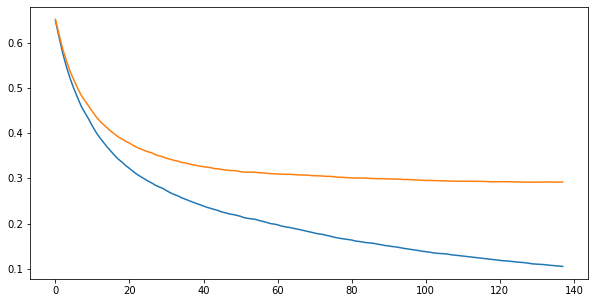

In [ ]:
epochs = len(results["validation_0"]["error"])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["validation_0"]["logloss"])
ax.plot(range(epochs), results["validation_1"]["logloss"])

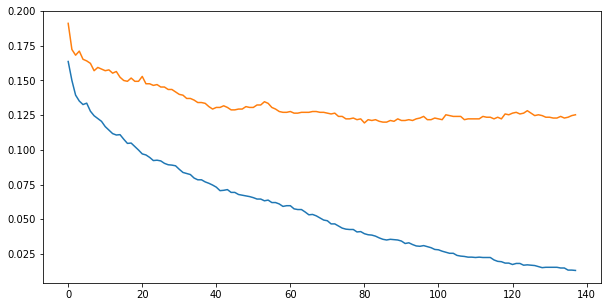

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["validation_0"]["error"])
ax.plot(range(epochs), results["validation_1"]["error"])

In [ ]:
# LGBMClassifier
param_dist = {
    "model__n_estimators": [1000, 5000, 10000],
    "model__learning_rate": [0.003, 0.01, 0.03, 0.1, 0.3],
    "model__max_depth": [8, 10, 12],
    "model__num_leaves": [25, 31, 35, 40],
    "model__reg_lambda": [0, 0.5, 1],
    "model__reg_alpha": [0, 0.5, 1],
    "model__colsample_bytree": [0.5, 0.6 0.75],
    "model__stopping_round": [10, 20]
}

selected_features = mrmr_classif(X=final_dfs[5], y=y_new, K=feature_sel_strategies[5])

pipe_lgbm = Pipeline(steps=[("trans_std", PowerTransformer()), ("model", LGBMClassifier())])

rand_clf = RandomizedSearchCV(pipe_lgbm,
                              param_dist,
                              n_iter=20,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=10)

rand_clf.fit(final_dfs[5][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', PowerTransformer()),
                 ('model',
                  LGBMClassifier(colsample_bytree=1, max_depth=12,
                                 n_estimators=5000, reg_alpha=0, reg_lambda=0.5,
                                 stopping_round=5))]), 0.8718386399187341)

In [ ]:
results_lgbm = get_scores(LGBMClassifier(colsample_bytree=1, max_depth=12,
                                         n_estimators=5000, reg_alpha=0, reg_lambda=0.5,
                                         stopping_round=10),
                          final_dfs[5], y_new, feature_sel_strategies[5])

100%|██████████| 29/29 [00:01<00:00, 22.92it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ................................ score: (test=0.892) total time=  27.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.6s remaining:    0.0s


[CV] END ................................ score: (test=0.855) total time=  26.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.3s remaining:    0.0s


[CV] END ................................ score: (test=0.894) total time=  27.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV] END ................................ score: (test=0.873) total time=  26.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=  26.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV] END ................................ score: (test=0.853) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.864) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.1min remaining:    0.0s


[CV] END ................................ score: (test=0.878) total time=  26.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s


[CV] END ................................ score: (test=0.860) total time=  27.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.0min remaining:    0.0s


[CV] END ................................ score: (test=0.869) total time=  26.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.5min finished


In [ ]:
results_lgbm

(0.8718386399187341,
 0.013477567793377103,
 array([0.89241623, 0.85537919, 0.89417989, 0.87301587, 0.87830688,
        0.85335689, 0.8639576 , 0.87809187, 0.86042403, 0.86925795]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(final_dfs[5][selected_features],
                                                  y_new, 
                                                  test_size=0.3, 
                                                  random_state=27)

lgbm_clf = LGBMClassifier(colsample_bytree=1, 
                          max_depth=12,
                          n_estimators=5000, 
                          reg_alpha=0, 
                          reg_lambda=0.5)

eval_set = [(X_train, y_train), (X_val, y_val)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=5, eval_metric=["error", "binary_logloss"], 
            eval_set=eval_set, verbose=50)

Training until validation scores don't improve for 5 rounds.
[50]	training's binary_logloss: 0.184481	training's binary_logloss: 0.184481	valid_1's binary_logloss: 0.316862	valid_1's binary_logloss: 0.316862
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.106832	training's binary_logloss: 0.106832	valid_1's binary_logloss: 0.300633	valid_1's binary_logloss: 0.300633


LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=5000, reg_alpha=0,
               reg_lambda=0.5)

In [ ]:
from sklearn.metrics import accuracy_score
y_preds = lgbm_clf.predict(X_val)
acc = accuracy_score(y_val, y_preds)
acc

0.8688235294117647

In [ ]:
results = lgbm_clf.evals_result_

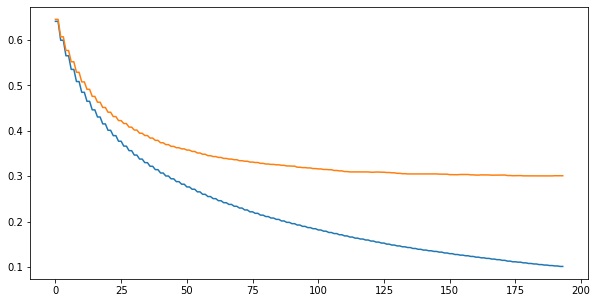

In [ ]:
epochs = len(results["training"]["binary_logloss"])
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(epochs), results["training"]["binary_logloss"])
ax.plot(range(epochs), results["valid_1"]["binary_logloss"]);

In [ ]:
#HistGradientBoostingClassifier
param_dist = {
    "model__learning_rate": [0.01, 0.03, 0.1, 0.3],
    "model__max_iter": [500, 1000, 2000],
    "model__early_stopping": [True],
    "model__n_iter_no_change": [10],
    "model__l2_regularization": [0, 1, 2],
    "model__max_depth": [6, 8, 10],
    "model__max_bins": [100, 150, 200, 255]
}

selected_features = mrmr_classif(X=final_dfs[6], y=y_new, K=feature_sel_strategies[6])

pipe_hgb = Pipeline(steps=[("trans_std", StandardScaler()), ("model", HistGradientBoostingClassifier())])

rand_clf = RandomizedSearchCV(pipe_hgb,
                              param_dist,
                              n_iter=50,
                              cv=StratifiedKFold(n_splits=10),
                              scoring="accuracy",
                              n_jobs=1,
                              verbose=50)

rand_clf.fit(final_dfs[6][selected_features], y_new)

In [ ]:
rand_clf.best_estimator_, rand_clf.best_score_

(Pipeline(steps=[('trans_std', StandardScaler()),
                 ('model',
                  HistGradientBoostingClassifier(early_stopping=True,
                                                 l2_regularization=1,
                                                 max_bins=150, max_depth=8,
                                                 max_iter=2000))]),
 0.8660138600656857)

In [ ]:
results_hgb = get_scores(HistGradientBoostingClassifier(early_stopping=True,
                                                        l2_regularization=1,
                                                        max_iter=500),
                         final_dfs[6], y_new, feature_sel_strategies[6])

100%|██████████| 41/41 [00:02<00:00, 18.35it/s]


In [ ]:
results_hgb

(0.8683053826163366,
 0.01725087293416374,
 array([0.90123457, 0.86067019, 0.89594356, 0.87830688, 0.85537919,
        0.85512367, 0.86925795, 0.85159011, 0.84982332, 0.86572438]))

In [ ]:
# CatBoostClassifier
cat_clf = CatBoostClassifier()

param_dist = {
    "iterations": [1000, 2000, 5000, 10000],
    "learning_rate": [0.003, 0.01, 0.03, 0.1],
    "depth": [4, 6, 8],
    "random_strength": [0, 1, 2],
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "early_stopping_rounds": [50],
    "custom_loss": ["AUC", "Accuracy"],
    "verbose": [50]
}

selected_features = mrmr_classif(X=final_dfs[7], y=y_new, K=feature_sel_strategies[7])

results = cat_clf.randomized_search(param_dist,
                                    X=final_dfs[7][selected_features],
                                    y=y_new,
                                    n_iter=20,
                                    cv=StratifiedKFold(n_splits=10),
                                    verbose=50)

In [ ]:
pd.DataFrame(results["cv_results"])

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,0.691548,0.000103,0.691501,0.000030,0.770342,0.009193,0.778131,0.004938
1,1,0.689877,0.000156,0.689791,0.000059,0.786582,0.014031,0.793527,0.006267
2,2,0.688190,0.000227,0.688068,0.000074,0.792405,0.015120,0.798391,0.005426
3,3,0.686605,0.000301,0.686432,0.000130,0.793995,0.012230,0.799647,0.005645
4,4,0.685108,0.000357,0.684897,0.000145,0.789234,0.015165,0.797214,0.006681
...,...,...,...,...,...,...,...,...,...
9995,9995,0.300201,0.031594,0.151488,0.022567,0.872014,0.016431,0.964383,0.013184
9996,9996,0.300201,0.031595,0.151484,0.022572,0.872014,0.016431,0.964383,0.013184
9997,9997,0.300200,0.031596,0.151481,0.022576,0.872014,0.016431,0.964383,0.013184
9998,9998,0.300199,0.031598,0.151479,0.022579,0.872014,0.016431,0.964383,0.013184


In [ ]:
results["params"]

{'custom_metric': 'AUC',
 'depth': 6,
 'iterations': 10000,
 'l2_leaf_reg': 9,
 'learning_rate': 0.01,
 'od_wait': 80,
 'random_strength': 2,
 'verbose': 50}

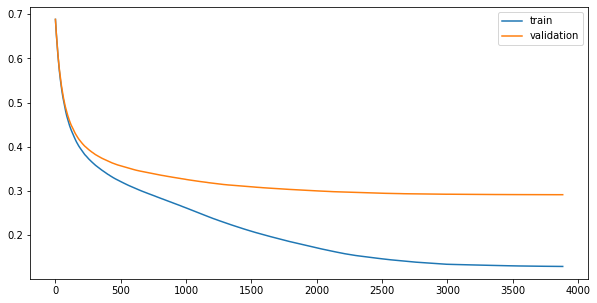

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results["cv_results"]["iterations"], results["cv_results"]["train-Logloss-mean"], label="train")
ax.plot(results["cv_results"]["iterations"], results["cv_results"]["test-Logloss-mean"], label="validation")
ax.legend()

In [ ]:
from catboost import cv, Pool
params = {
    "iterations": 10000,
    "depth": 6,
    'l2_leaf_reg': 9,
    'learning_rate': 0.01,
    'od_wait': 80,
    'random_strength': 2,
    "loss_function": "Logloss",
    "custom_loss": ["Accuracy", "AUC"]
}

selected_features = mrmr_classif(X=final_dfs[7], y=y_new, K=feature_sel_strategies[7])

pool = Pool(data=final_dfs[7][selected_features],
            label=y_new)
cv_data = cv(
    params=params,
    pool=pool,
    folds=StratifiedKFold(n_splits=10),
    shuffle=True,
    partition_random_seed=0,
    verbose=100,
    #early_stopping_rounds=50
)

In [ ]:
pd.DataFrame(cv_data)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-AUC-mean,test-AUC-std
0,0,0.687970,0.000264,0.687880,0.000108,0.755692,0.013576,0.759714,0.003763,0.821098,0.019496
1,1,0.683595,0.000550,0.683425,0.000156,0.765402,0.015404,0.770932,0.004330,0.840594,0.019545
2,2,0.678714,0.000689,0.678430,0.000264,0.780227,0.017054,0.783564,0.004526,0.858782,0.017733
3,3,0.674287,0.000858,0.673936,0.000340,0.789583,0.019177,0.790546,0.004687,0.862516,0.016245
4,4,0.669961,0.000987,0.669470,0.000516,0.791700,0.019600,0.795194,0.003207,0.866914,0.015906
...,...,...,...,...,...,...,...,...,...,...,...
3708,3708,0.292973,0.029127,0.130051,0.019088,0.871131,0.016973,0.977621,0.009552,0.945666,0.011624
3709,3709,0.292970,0.029134,0.130047,0.019095,0.871131,0.016973,0.977621,0.009552,0.945669,0.011629
3710,3710,0.292969,0.029135,0.130044,0.019099,0.871131,0.016973,0.977621,0.009552,0.945669,0.011629
3711,3711,0.292964,0.029145,0.130040,0.019107,0.871131,0.016973,0.977621,0.009552,0.945669,0.011629


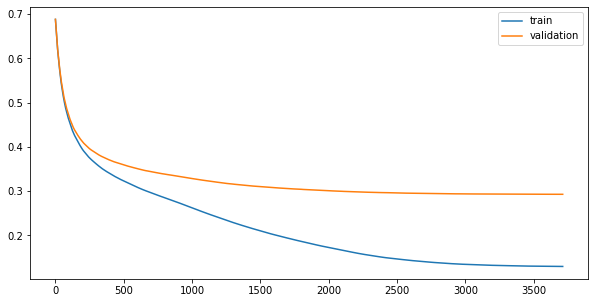

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_data["iterations"], cv_data["train-Logloss-mean"], label="train")
ax.plot(cv_data["iterations"], cv_data["test-Logloss-mean"], label="validation")
ax.legend()

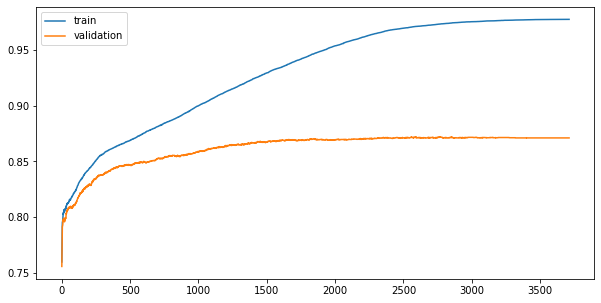

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(cv_data["iterations"], cv_data["train-Accuracy-mean"], label="train")
ax.plot(cv_data["iterations"], cv_data["test-Accuracy-mean"], label="validation")
ax.legend()

# Preparing Test Data and Final Predictions

In [ ]:
log_reg = LogisticRegression(C=0.5, max_iter=300)
knn_clf = KNeighborsClassifier(n_neighbors=11, weights='distance')
svc = SVC(C=3, tol=0.0001)
rf_clf = RandomForestClassifier(max_features=0.5, min_samples_leaf=2, min_samples_split=8)
xgb_clf = XGBClassifier(n_estimators=5000, colsample_bytree=0.5, early_stopping_rounds=10, 
                        eta=0.3, reg_lambda=5, max_depth=6, model__verbosity=2)
lgbm_clf = LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=5000, 
                          reg_alpha=0, reg_lambda=0.5, stopping_round=5)
hgb_clf = HistGradientBoostingClassifier(early_stopping=True, l2_regularization=1, max_bins=150,
                                         max_depth=8, max_iter=2000)
cat_clf = CatBoostClassifier(iterations=10000, depth=6, l2_leaf_reg=9, learning_rate=0.01, 
                             od_wait=80, random_strength=2)
list_of_final_models = [log_reg, knn_clf, svc, rf_clf, xgb_clf, lgbm_clf, hgb_clf, cat_clf]

In [ ]:
with open("drive/MyDrive/US Elections/Notebook Data/corr_strategies.pickle", "rb") as corr_strategies_:
  corr_strategies = pickle.load(corr_strategies_)

In [ ]:
def preprocess_testset(X_train, y_train, X_test, y_test, fg_df, corr_strategies, corr_dfs):
  # Creating copy of test set
  X_test_new = X_test.reset_index(drop=True).copy()
  y_test_new = y_test.reset_index(drop=True).copy()

  # Imputing and encoding
  X_test_new["monthly housing costs - median"] = X_test_new["monthly housing costs - median"].fillna(X_test_new["monthly housing costs - median"].median())
  X_test_new["district"] = X_test_new["district"].astype("category").cat.codes
  X_test_new["state"] = X_test_new["state"].astype("category").cat.codes
  
  # Interactions
  X_interactions = pd.DataFrame()
  X_interactions["district*state"] = X_test_new["district"] * X_test_new["state"]
  X_interactions["district*percent uninsured"] = X_test_new["district"] * X_test_new["percent uninsured"]

  # Tree-based Feature Generation
  fg_strategy, fg_dataframes = {}, {}
  for num in range(8):
    strat = fg_df[fg_df.iloc[:, (num*4):(num+1)*4].columns].mean().idxmax().split("_")
    fg_strategy[strat[0]] = strat[-1]

  for num, (model, depth) in enumerate(fg_strategy.items()):
    gbfg = GradientBoostingFeatureGenerator(stack_to_X=False, n_estimators=1, max_depth=int(depth))
    # Fit on training set
    gbfg.fit(X_train, y_train)
    # Transform test set
    X_new = np.asarray(gbfg.transform(X_test_new))
    fg_dataframes[model] = pd.DataFrame(X_new, columns=[f"fg_{i}" for i in range(X_new.shape[1])])

  # Dropping correlated Features
  corr_dfs_test = {}
  for model, df in corr_dfs.items():
    cols_dropped = list(set(X_test_new.columns).symmetric_difference(set(df.columns)))
    corr_dfs_test[str(model)] = cols_dropped
  
  # Putting Datasets for different algorithms together
  X_test_base = pd.concat([X_test_new, X_interactions], axis=1)
  #return X_test_base, corr_dfs_test
  X_test_dfs = []
  for (model, fg_df), (model_, cols) in zip(fg_dataframes.items(), corr_dfs_test.items()):
    #X_test_base_dropped = X_test_base.drop(cols, axis=1)
    #X_test_final = pd.concat([X_test_base_dropped, fg_df], axis=1)
    X_test_final = pd.concat([X_test_base, fg_df], axis=1)
    X_test_dfs.append(X_test_final)
  
  return X_test_dfs

In [ ]:
X_test_prepared = preprocess_testset(X, y, X_test, y_test, fg_df, corr_strategies, corr_dfs)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def final_predictions(final_dfs_normal, y_train, X_test_prepared, y_test, list_of_final_models, 
                      feature_sel_strategies):
  scores = pd.DataFrame()
  for num, (train, test) in enumerate(zip(final_dfs_normal, X_test_prepared)):
    print(num)
    # Feature Selection with mrmr
    selected_features = mrmr_classif(X=train, y=y_train, K=feature_sel_strategies[num])
    print(len(selected_features))
    
    # Transforming and Standardizing
    trans_std = PowerTransformer()
    train_prepared = trans_std.fit_transform(train[selected_features])
    train_prepared = pd.DataFrame(train_prepared, columns=trans_std.get_feature_names_out())
    test_prepared = trans_std.transform(test[selected_features])
    test_prepared = pd.DataFrame(test_prepared, columns=trans_std.get_feature_names_out())
    
    # Model fitting and get prediction probabilities
    model = list_of_final_models[num]
    model.fit(train_prepared[selected_features], y_train)
    test_preds = model.predict(test_prepared[selected_features])
    
    # Saving results
    scores.loc["accuracy", str(list_of_final_models[num])] = accuracy_score(y_test, test_preds)
    scores.loc["auc", str(list_of_final_models[num])] = roc_auc_score(y_test, test_preds)
    scores.loc["precision", str(list_of_final_models[num])] = precision_score(y_test, test_preds)
    scores.loc["recall", str(list_of_final_models[num])] = recall_score(y_test, test_preds)
  return scores

In [ ]:
test_results = final_predictions(final_dfs, y_new, X_test_prepared, y_test, list_of_final_models, 
                                 feature_sel_strategies)

In [ ]:
test_results

,"LogisticRegression(C=0.5, max_iter=300)","KNeighborsClassifier(n_neighbors=11, weights='distance')","SVC(C=3, tol=0.0001)","RandomForestClassifier(max_features=0.5, min_samples_leaf=2,\n min_samples_split=8)","XGBClassifier(colsample_bytree=0.5, early_stopping_rounds=10, eta=0.3,\n max_depth=6, model__verbosity=2, n_estimators=5000, reg_lambda=5)","LGBMClassifier(colsample_bytree=1, max_depth=12, n_estimators=5000, reg_alpha=0,\n reg_lambda=0.5, stopping_round=5)","HistGradientBoostingClassifier(early_stopping=True, l2_regularization=1,\n max_bins=150, max_depth=8, max_iter=2000)",<catboost.core.CatBoostClassifier object at 0x7fe8235eb710>
accuracy,0.825304,0.840656,0.847538,0.841186,0.862361,0.858126,0.856008,0.862890
auc,0.821186,0.836333,0.842591,0.838796,0.861020,0.856485,0.854173,0.861329
precision,0.833958,0.855164,0.870347,0.837515,0.852975,0.850764,0.850059,0.855634
recall,0.772254,0.784971,0.783815,0.810405,0.845087,0.836994,0.832370,0.842775
